# EN4 Pre-Processing

## Imports

In [146]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
from zipfile import ZipFile
import gsw
import pandas as pd
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import time
import datetime
from scipy.stats import linregress
from scipy.stats import t
import cmocean.cm as cmo
from erddapy import ERDDAP
import matplotlib.gridspec as gridspec


## First go here to download data:
https://www.metoffice.gov.uk/hadobs/en4/download-en4-2-2.html

Follow instructions to use wget to download data. I should probably do this one file at a time but this way is fine...... maybe. This is 16 GB of data and takes a long time but can then delete the tmp data after this workflow. I also have enough storage locally right now for this.

## Then unzip data

In [2]:
# zipnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/tmp/*.zip')

# for z in np.arange(0,len(zipnames)): 
#     ZipFile(zipnames[z]).extractall('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/extracted/')

## Functions for pre-processing

In [147]:

def get_erddap_dataset(ds_id, server, variables=None, constraints=None, filetype=None):
    ## Written by Mike Smith
    """
    Returns a netcdf dataset for a specified dataset ID (or dataframe if dataset cannot be converted to xarray)
    :param ds_id: dataset ID e.g. ng314-20200806T2040
    :param variables: optional list of variables
    :param constraints: optional list of constraints
    :param filetype: optional filetype to return, 'nc' (default) or 'dataframe'
    :return: netcdf dataset
    """
    variables = variables or None
    constraints = constraints or None
    filetype = filetype or 'nc'
    #ioos_url = 'https://data.ioos.us/gliders/erddap'


    e = ERDDAP(server,
               protocol='tabledap',
               response='nc')
    e.dataset_id = ds_id
    if constraints:
        e.constraints = constraints
    if variables:
        e.variables = variables
    if filetype == 'nc':
        try:
            ds = e.to_xarray()
            ds = ds.sortby(ds.time)
        except OSError:
            print('No dataset available for specified constraints: {}'.format(ds_id))
            ds = []
        except TypeError:
            print('Cannot convert to xarray, providing dataframe: {}'.format(ds_id))
            ds = e.to_pandas().dropna()
    elif filetype == 'dataframe':
        #ds = e.to_pandas().dropna()
        ds = e.to_pandas().dropna(how='all')
    else:
        print('Unrecognized filetype: {}. Needs to  be "nc" or "dataframe"'.format(filetype))

    return ds


def subset(ds,lon_min,lon_max,lat_min,lat_max):
    ## profiles that fulfill the lat/lon ranges
    ind = np.where((ds.LONGITUDE>=lon_min) & (ds.LONGITUDE<=lon_max) &
                   (ds.LATITUDE>=lat_min)  & (ds.LATITUDE<=lat_max))[0]
    ## subset
    subset_ds = xr.merge([ds.PSAL_CORRECTED[ind,:],
                      ds.POTM_CORRECTED[ind,:],
                      ds.DEPH_CORRECTED[ind,:],
                      ds.POSITION_QC[ind],
                      ds.PROFILE_POTM_QC[ind],
                      ds.PROFILE_PSAL_QC[ind],
                      ds.POTM_CORRECTED_QC[ind],
                      ds.PSAL_CORRECTED_QC[ind],
                      ds.INST_REFERENCE[ind],
                      ds.JULD[ind],
                      ds.LONGITUDE[ind],
                      ds.LATITUDE[ind],
                     ],combine_attrs='drop')
    return subset_ds




def qaqc(ds):
    ## Pull out profiles that fail check
    position_qc_ind = np.where(ds.POSITION_QC == b'4')[0]
    profile_potm_qc_ind = np.where(ds.PROFILE_POTM_QC == b'4')[0]
    profile_psal_qc_ind = np.where(ds.PROFILE_PSAL_QC == b'4')[0]
    potm_corrected_qc_ind = np.where(ds.POTM_CORRECTED_QC == b'4')[0]
    psal_corrected_qc_ind = np.where(ds.PSAL_CORRECTED_QC == b'4')[0]
    ## Combine indicies
    tot_qc_ind = np.unique(np.concatenate([position_qc_ind,profile_potm_qc_ind,profile_psal_qc_ind,potm_corrected_qc_ind,psal_corrected_qc_ind]))
    ## Remove from dataset
    ds.PSAL_CORRECTED[tot_qc_ind,:] = np.nan
    ds.POTM_CORRECTED[tot_qc_ind,:] = np.nan
    return ds




def gsw_convert(ds):
    
    lats = np.tile(ds.LATITUDE,(len(ds.N_LEVELS),1)).transpose()
    lons = np.tile(ds.LONGITUDE,(len(ds.N_LEVELS),1)).transpose()
    pressure = gsw.p_from_z(-ds.DEPH_CORRECTED, lats, geo_strf_dyn_height=0, sea_surface_geopotential=0)

    ds['absolute_salinity'] = gsw.SA_from_SP(ds.PSAL_CORRECTED, pressure, lons, lats)    
    ds['conservative_temperature'] = gsw.CT_from_pt(ds.absolute_salinity, ds.POTM_CORRECTED)
    
    return ds





def depth_grid(ds):
    ########################################################################################################################
    #### Depth grid interpolation
    depth_grid = np.concatenate([np.arange(0,101,5),np.arange(125,251,25),np.arange(300,1501,50),np.arange(1550,2051,250)])

    temp_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    salt_interp = np.empty((len(depth_grid),ds.conservative_temperature.shape[1]))
    

    for x in np.arange(0,ds.conservative_temperature.shape[1]):
        temp_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.conservative_temperature[:,x], left=np.nan, right=np.nan)
        salt_interp[:,x] = np.interp(depth_grid, ds.DEPH_CORRECTED.values[:,x], ds.absolute_salinity[:,x], left=np.nan, right=np.nan)
    ########################################################################################################################

    ## Check which profiles are NOT all nans
    non_nan_ind = np.where(np.sum(np.isnan(salt_interp),axis=0)!=len(depth_grid))[0]

    new_ds = xr.Dataset(
        data_vars=dict(
            conservative_temperature = (["depth", "time"], temp_interp[:,non_nan_ind]),
            absolute_salinity        = (["depth", "time"], salt_interp[:,non_nan_ind]),
            longitude                = (["time"], ds.LONGITUDE.values[non_nan_ind]),
            latitude                 = (["time"], ds.LATITUDE.values[non_nan_ind]),
            obs_type                 = (["time"], ds.INST_REFERENCE.values[non_nan_ind]))
            ,
        coords=dict(
            depth = depth_grid,
            time  = ds.JULD.values[non_nan_ind]))
    
    new_ds = new_ds.sortby('time')

    return new_ds


def depth_grid_glider(ds):
    ########################################################################################################################
    #### Depth grid interpolation
    depth_grid = np.concatenate([np.arange(0,101,5),np.arange(125,251,25),np.arange(300,1501,50),np.arange(1550,2051,250)])
    
    ## Number of profiles!
    source_files = np.unique(ds.source_file.values)   

    ## Pre-allocate
    temp_interp = np.empty((len(depth_grid),len(source_files)))
    temp_interp[:] = np.nan
    salt_interp = np.empty((len(depth_grid),len(source_files)))
    salt_interp[:] = np.nan
    lats = np.empty(len(source_files))
    lats[:] = np.nan
    lons = np.empty(len(source_files))
    lons[:] = np.nan
    times = np.empty(len(source_files), dtype='datetime64[s]')
    times[:] = np.datetime64('nat')

    for x in np.arange(0,len(source_files)):
        ## Subset
        subset_ds = ds[ds['source_file'] == source_files[x]]
        subset_ds = subset_ds.sort_values(by='depth')


        # temp_interp[:,x] = np.interp(depth_grid, subset_ds.depth.values, subset_ds.conservative_temperature.values)
        # salt_interp[:,x] = np.interp(depth_grid, subset_ds.depth.values, subset_ds.absolute_salinity.values)
        temp_interp[:,x] = np.interp(depth_grid, subset_ds.depth.values, subset_ds.conservative_temperature.values, left=np.nan, right=np.nan)
        salt_interp[:,x] = np.interp(depth_grid, subset_ds.depth.values, subset_ds.absolute_salinity.values, left=np.nan, right=np.nan)
        lons[x] = np.nanmean(subset_ds.longitude.values)
        lats[x] = np.nanmean(subset_ds.latitude.values)
        times[x] = np.datetime64(subset_ds.time.mean())

    ########################################################################################################################

    new_ds = xr.Dataset(
        data_vars=dict(
            conservative_temperature = (["depth", "time"], temp_interp),
            absolute_salinity        = (["depth", "time"], salt_interp),
            longitude                = (["time"], lons),
            latitude                 = (["time"], lats),
            obs_type                 = (["time"], np.repeat(np.nan,len(source_files))))
            ,
        coords=dict(
            depth = depth_grid,
            time  = times))
    
    new_ds = new_ds.sortby('time')

    return new_ds


def depth_grid_wipp(ds):
    ########################################################################################################################
    #### Depth grid interpolation
    depth_grid = np.concatenate([np.arange(0,101,5),np.arange(125,251,25),np.arange(300,1501,50),np.arange(1550,2051,250)])
    
    ## Pre-allocate
    temp_interp = np.empty((len(depth_grid),1))
    temp_interp[:] = np.nan
    salt_interp = np.empty((len(depth_grid),1))
    salt_interp[:] = np.nan

    # temp_interp[:,0] = np.interp(depth_grid, ds.depth.values, ds.conservative_temperature.values)
    # salt_interp[:,0] = np.interp(depth_grid, ds.depth.values, ds.absolute_salinity.values)
    temp_interp[:,0] = np.interp(depth_grid, ds.depth.values, ds.conservative_temperature.values, left=np.nan, right=np.nan)
    salt_interp[:,0] = np.interp(depth_grid, ds.depth.values, ds.absolute_salinity.values, left=np.nan, right=np.nan)
    lons = np.nanmean(ds.lon.values)
    lats = np.nanmean(ds.lat.values)
    time = np.datetime64(ds.date.mean())

    ########################################################################################################################

    new_ds = xr.Dataset(
        data_vars=dict(
            conservative_temperature = (["depth", "time"], temp_interp),
            absolute_salinity        = (["depth", "time"], salt_interp),
            longitude                = (["time"], np.atleast_1d(lons)),
            latitude                 = (["time"], np.atleast_1d(lats)),
            obs_type                 = (["time"], np.atleast_1d(np.nan)))
            ,
        coords=dict(
            depth = depth_grid,
            time  = np.atleast_1d(time)))
    

    return new_ds


def spatial_grid_and_carib_clip(ds,lon_step,lat_step,time=None):

    ########################################################################################################################
    #### Spatial grid
    # lon_step = 0.5 # degrees
    # lat_step = 0.5 # degrees

    ## Went larger than shapefile and then clip will trim
    lon_gridt = np.arange(-95,-55,lon_step)
    lat_gridt = np.arange(5,25,lat_step)

    ## Lat/Lon grid mid points
    mid_lons = lon_gridt+(lon_step/2)
    mid_lats = lat_gridt+(lat_step/2)

    ## For total anomaly
    if time == None:
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt)))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt)))
        grid_salt[:]  = np.nan
        grid_count    = np.empty((len(lat_gridt), len(lon_gridt)))
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            for y in np.arange(0,len(lat_gridt)-1):
                grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_gridt[y])   &
                                    (ds.latitude.values  <= lat_gridt[y+1]))[0]
                
                grid_temp[:,y,x] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
                grid_salt[:,y,x] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
                grid_count[y,x]  = len(grid_ind)
    
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth","latitude", "longitude"], grid_temp),
                absolute_salinity=(["depth","latitude", "longitude"], grid_salt),
                num_profs = (["latitude","longitude"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=mid_lats,
                depth=ds.depth.values,
            ))
    ## Because adding time dimension
    else:
        ## Preallocate
        grid_temp     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        grid_temp[:]  = np.nan
        grid_salt     = np.empty((len(ds.depth), len(lat_gridt), len(lon_gridt),1))
        grid_salt[:]  = np.nan
        grid_count    = np.empty((len(lat_gridt), len(lon_gridt),1))
        grid_count[:] = np.nan
        
        ## Stuff data in the grid cells!
        for x in np.arange(0,len(lon_gridt)-1):
            for y in np.arange(0,len(lat_gridt)-1):
                grid_ind = np.where((ds.longitude.values >= lon_gridt[x])   & 
                                    (ds.longitude.values <= lon_gridt[x+1]) &
                                    (ds.latitude.values  >= lat_gridt[y])   &
                                    (ds.latitude.values  <= lat_gridt[y+1]))[0]
                
                grid_temp[:,y,x,0] = ds.conservative_temperature[:,grid_ind].mean(axis=1)
                grid_salt[:,y,x,0] = ds.absolute_salinity[:,grid_ind].mean(axis=1)
                grid_count[y,x,0]  = len(grid_ind)
    
        
        
        ### Make a new gridded dataset
        grid_ds = xr.Dataset(
            data_vars=dict(
                conservative_temperature=(["depth","latitude", "longitude","time"], grid_temp),
                absolute_salinity=(["depth","latitude", "longitude","time"], grid_salt),
                num_profs = (["latitude","longitude","time"],grid_count),
            ),
            coords=dict(
                longitude=mid_lons,
                latitude=mid_lats,
                depth=ds.depth.values,
                time=np.atleast_1d(pd.to_datetime(time)),
            ))

    ## For clipping to Caribbean shapefile
    grid_ds = grid_ds.rio.write_crs('WGS84', inplace=True)
    ## Clip to Caribbean shapefile, this will actually shorten the lat and lon coordinates which is why I went to a bigger extent above
    grid_ds = grid_ds.rio.clip(carib.geometry.values, carib.crs)
    
    return grid_ds


def load_and_grid_glider(ds_id):
    #ds_id = 'ru29-20200908T1623-profile-sci-delayed'

    ## Load flight data
    variables = ['depth','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity','source_file']
    gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
    gdf.columns = variables

    ## Reformat time
    gdf['time'] = pd.to_datetime(gdf['time'])

    ## Absolute salinity
    gdf['absolute_salinity'] = gsw.SA_from_SP(gdf.salinity.values, gdf.pressure.values, gdf.longitude.values, gdf.latitude.values)
    ## Conservative temperature
    gdf['conservative_temperature'] = gsw.CT_from_t(gdf['absolute_salinity'], gdf.potential_temperature.values, gdf.pressure.values)
    
    ## Depth grid
    grid_ds = depth_grid_glider(gdf)
    
    return grid_ds


def process_wimp_ctd(fname,stnloc,ind):    
    def convert_ind(ind):
        ### Needs to be a length 3 string for indexing stnloc pkl file
        if len(str(ind)) == 3:
            ind = str(ind)
        elif len(str(ind)) == 2:
            ind = '0'+str(ind)
        elif len(str(ind)) ==1:
            ind = '00'+str(ind)
        return ind
    ## Convert
    ind = convert_ind(ind)
    
    ## Subset
    stnloc_subset = stnloc[stnloc.stn_num==ind]
    
    cfile=np.genfromtxt(fname,unpack=True,filling_values=np.nan)
    if len(cfile) > 0:
        ctd_cols=['depth','temperature','salinity']
        ctd_raw=pd.DataFrame({ctd_cols[0]:cfile[0],ctd_cols[1]:cfile[1],ctd_cols[2]:cfile[2]})
        ctd_raw['depth']=ctd_raw['depth'].astype(float) #need to get pressure from depth gs.p_from_z(z,lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)
        ctd_raw['temperature']=ctd_raw['temperature'].astype(float) #need to convert gsw.CT_from_t(SA,t,p)
        ctd_raw['salinity']=ctd_raw['salinity'].astype(float) #need to convert gsw.SA_from_SP(SP,p,lon,lat)
        ## Convert to conservative temperature and absolute salinity
        ctd_raw['pressure']=gsw.p_from_z(-ctd_raw.depth.values,stnloc_subset.lat.values,geo_strf_dyn_height=0, sea_surface_geopotential=0)
        ctd_raw['absolute_salinity']=gsw.SA_from_SP(ctd_raw.salinity.values,ctd_raw.pressure.values,stnloc_subset.lon.values,stnloc_subset.lat.values)
        ctd_raw['conservative_temperature'] = gsw.CT_from_t(ctd_raw.absolute_salinity.values,ctd_raw.temperature.values,ctd_raw.pressure.values)
        ## Add metadata
        ctd_raw['lat'] = np.repeat(stnloc_subset.lat.values,len(ctd_raw['conservative_temperature']))
        ctd_raw['lon'] = np.repeat(stnloc_subset.lon.values,len(ctd_raw['conservative_temperature']))
        ctd_raw['date'] = np.repeat(stnloc_subset.date.values,len(ctd_raw['conservative_temperature']))
    else:
        ctd_raw = pd.DataFrame({'depth':np.atleast_1d(np.nan),
                                'temperature':np.atleast_1d(np.nan),
                                'salinity':np.atleast_1d(np.nan),
                                'pressure':np.atleast_1d(np.nan),
                                'absolute_salinity':np.atleast_1d(np.nan),
                                'conservative_temperature':np.atleast_1d(np.nan),
                                'lat':np.atleast_1d(np.nan),
                                'lon':np.atleast_1d(np.nan),
                                'date':np.atleast_1d(np.nan)})    
    return ctd_raw

def ocean_heat_content(depth, temp, density):
    """
    This function Calculates the ocean heat content from a temperature and
    density profile (Leipper, Dale F., and Douglas Volgenau. "Hurricane heat
    potential of the Gulf of Mexico". Journal of Physical Oceanography 2.3
    (1972): 218-224).

    Q = ρ Cp ΔT ΔZ

    Q: Hurricane Heat Potential
    ρ: density (gm cm-3)
    Cp: specific heat at constant pressure (cal cm-3) (C)
    ΔT: Average temperature difference above 26C for a given depth increment
    ΔZ: Depth increment (taken as 500cm)

    Args:
        depth (numpy.ndarray or pandas.Series or xarray.Series): depth (m)
        temp (numpy.ndarray or pandas.Series or xarray.Series): temperature (c)
        dens (numpy.ndarray or pandas.Series or xarray.Series): density (gm/cm^3)

    Returns:
        numpy.ndarray: Ocean heat content of the water column in kJ/cm^2
    """

    cp = 3985  # Heat capacity in J/(kg K)

    ## Make sure temperature profile goes down to 26
    min_temp = np.nanmin(temp)
    if min_temp > 26:
        temp[:] = np.nan
    
    temp_mask = temp >= 26  # only want data greater than or equal to 26C
    depth = np.abs(depth)  # absolute value of depth

    # Mask the variables based off the temperature mask
    depth_m = depth[temp_mask]
    density_m = density[temp_mask]
    temp_m = temp[temp_mask]

    # If the number of depths do not equal 0
    if len(depth_m) != 0:
        # If the minimum depth is shallower than 10m
        if np.nanmin(depth_m) > 10:
            OHC = np.nan
        # If the minimum depth is deeper than 10m
        else:
            rho0 = np.nanmean(density_m)  # don't include nans
            OHC = np.abs(cp * rho0 * np.trapz(temp_m - 26, depth_m))
            OHC = OHC * 10 ** (-7)  # in kJ/cm^2
    # If the number of depths do equal 0
    else:
        OHC = np.nan
    return OHC



################################################################################
def potential_energy_anomaly(depth, dens,max_depth=100,min_depth=0):
    """
    This function calculates the potential energy anomaly
    (Simpson J, Brown J, Matthews J, Allen G (1990) Tidal straining, density
    currents and stirring in the control of estuarine stratification.
    Estuaries 13(2):125-132), in the top 100 meters

    Args:
        depth (numpy.ndarray or pandas.Series or xarray.Series): depth
        dens (numpy.ndarray or pandas.Series or xarray.Series): density

    Returns:
        np.ndarray: potential energy anomaly in J/m^3
    """

    g = 9.8 #m/s
    dindex = np.fliplr(np.where((np.asarray(np.abs(depth)) <= max_depth) & (np.asarray(np.abs(depth)) >= min_depth)))[0]
    if len(dindex) == 0:
        PEA = np.nan
    else:
        zz = np.asarray(np.abs(depth[dindex]))
        denss = np.asarray(dens[dindex])
        ok = np.isfinite(denss)
        z = zz[ok]
        densi = denss[ok]
        if len(z)==0 or len(densi)==0:
            PEA = np.nan
        else:
            if z[-1] - z[0] > 0:
                # So PEA is < 0
                # sign = -1
                # Adding 0 to sigma integral is normalized
                z = np.append(0,z)
            else:
                # So PEA is < 0
                # sign = 1
                # Adding 0 to sigma integral is normalized
                z = np.flipud(z)
                z = np.append(0,z)
                densit = np.flipud(densi)

            # adding density at depth = 0
            densitt = np.interp(z,z[1:],densit)
            density = np.flipud(densitt)

            # defining sigma
            max_depth = np.nanmax(zz[ok])
            sigma = -1*z/max_depth
            sigma = np.flipud(sigma)

            rhomean = np.trapz(density,sigma,axis=0)
            drho = rhomean - density
            torque = drho * sigma
            PEA = g * max_depth * np.trapz(torque,sigma,axis=0)

    return PEA



def water_mass_decomposition(old_salt,old_temp,old_den,new_salt,new_temp,new_den,new_depth):
    ## Calculate dz
    dz = np.diff(new_depth)[0]

    ## Change in isopycnal depth
    drho = np.empty(len(new_depth))    
    for x in np.arange(0,len(new_depth)):
        if np.sum(np.isnan(np.abs(np.abs(old_den[x]-new_den)))) == len(new_den):
            break
        else:
            drho[x] = (new_depth[np.nanargmin(np.abs(old_den[x]-new_den))]-new_depth[x])

    ## Local vertical change in temp/salt 
    dtheta_dz = np.gradient(new_temp,dz)
    dsalt_dz = np.gradient(new_salt,dz)

    ## Heave component of the change in temp/salt
    heave_temp = (dtheta_dz*drho)
    heave_salt = (dsalt_dz*drho)

    ## Change in temp/salt on isopycnal
    spice_salt = np.empty(len(new_depth))
    spice_temp = np.empty(len(new_depth))
    isopyc_depth_delta = np.empty(len(new_depth))
    
    for x in np.arange(0,len(new_depth)):
        if np.sum(np.isnan(np.abs(old_den[x]-new_den))) == len(new_den):
            break
        else:
            ## First find the index the isopycnal changed to
            ind = np.nanargmin(np.abs(old_den[x]-new_den))
            ## Then diff the temps/salts on that isopycnal
            spice_temp[x] = new_temp[ind]-old_temp[x]
            spice_salt[x] = new_salt[ind]-old_salt[x]
            ## How much that isopycnal has moved vertically
            isopyc_depth_delta[x] = new_depth[ind]-new_depth[x]

    ## Total temp/salt differences
    temp_diff = new_temp-old_temp
    salt_diff = new_salt-old_salt

    ## Residuals
    temp_resid = temp_diff-(spice_temp-heave_temp)
    salt_resid = salt_diff-(spice_salt-heave_salt)

    ## Combine into a df
    d = {'depth': new_depth, 'temp_diff': temp_diff, 'heave_temp': heave_temp,
    'spice_temp': spice_temp, 'temp_resid': temp_resid, 'salt_diff': salt_diff,
    'heave_salt': heave_salt, 'spice_salt': spice_salt, 'salt_resid': salt_resid,'isopyc_depth_delta':isopyc_depth_delta}

    df = pd.DataFrame(data=d)


    return df

    






### These were pulled from: https://github.com/KirstieJane/STATISTICS/blob/master/CIs_LinearRegression.py

def lin_fit(x,y):
    '''
    Predicts the values for a best fit between numpy arrays x and y

    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)

    Returns
    -------
    p:     parameters for linear fit of x to y
    y_err: 1D array of difference between y and fit values
               (same length as x)

    '''

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    fit = p(x)

    y_err = y - fit

    return p, y_err

# ----------------------------------------------------------------------------

def conf_calc(x, y_err, c_limit=0.975, test_n=50):
    '''
    Calculates confidence interval of regression between x and y

    Parameters
    ----------
    x:       1D numpy array
    y_err:   1D numpy array of residuals (y - fit)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)

    Returns
    -------
    p_x:   1D array, length "test_n", with values spread evenly between
           min(x) and max(x)
    confs: 1D numpy array of predicted y values for x inputs

    '''
    # Define the variables you need
    # to calculate the confidence interval
    mean_x = np.mean(x)			# mean of x
    n = len(x)				# number of samples in origional fit
    tstat = t.ppf(c_limit, n-1)         # appropriate t value
    s_err = np.sum(np.power(y_err,2))	# sum of the squares of the residuals

    # create series of new test x-values to predict for
    p_x = np.linspace(np.min(x),np.max(x),test_n)

    confs = tstat * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
			((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    return p_x, confs

# ----------------------------------------------------------------------------

def ylines_calc(p_x, confs, fit):
    '''
    Calculates the three lines that will be plotted

    Parameters
    ----------
    p_x:   1D array with values spread evenly between min(x) and max(x)
    confs: 1D array with confidence values for each value of p_x
    fit:   Predicted x -> y function (typically derived from np.poly1d)

    Returns
    -------
    p_y:    1D array with values corresponding to fit line (for p_x values)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line

    '''
    # now predict y based on test x-values
    p_y = fit(p_x)

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    return p_y, lower, upper

# ----------------------------------------------------------------------------

def plot_linreg_CIs(x, y, p_x, p_y, lower, upper):

    # set-up the plot
    #plt.xlabel('X values')
    #plt.ylabel('Y values')
    #plt.title('Linear regression and confidence limits')

    # plot sample data
    #plt.plot(x, y, 'bo', label='Sample observations')

    # plot line of best fit
    plt.plot(p_x, p_y, 'r-', color='black')

    # plot confidence limits
    plt.plot(p_x, lower, color='grey')
    plt.plot(p_x, upper, color='grey')

    # show the plot
    #plt.show()


def confidence_bounds(x, y, c_limit=0.975, test_n=50):
    '''
    Calculates the predicted (trend) line, and lower & upper confidene bounds
    from original x,y measurements

    Parameters
    ----------
    x: 1D numpy array
    y: 1D numpy array (same length as x)
    c_limit: (optional) float number representing the area to the left
             of the critical value in the t-statistic table
             eg: for a 2 tailed 95% confidence interval (the default)
                    c_limit = 0.975
    test_n:  (optional) integer representing numer of equally-spaced
             x-points to predict in the range min(x) to max(x)

    Returns
    -------
    p_x:    1D array with values spread evenly between min(x) and max(x)
            (length test_n)
    p_y:    1D array with values corresponding to fit line (for p_x values)
            (length test_n)
    upper:  1D array, values corresponding to upper confidence limit line
    lower:  1D array, values corresponding to lower confidence limit line

    '''

    # Fit x to y
    p, y_err = lin_fit(x ,y)

    # Calculate confidence intervals
    p_x, confs = conf_calc(x, y_err, c_limit=c_limit, test_n=test_n)

    # Calculate the lines for plotting:
    # The fit line, and lower and upper confidence bounds
    p_y, lower, upper = ylines_calc(p_x, confs, p)

    return p_x, p_y, lower, upper


    

# Pre-Processing Step 1:

**This does the following, looping through each file which represents all the data from a month in a year:**
1) Loads data
2) Subsets to VERY wide Caribbean box
3) QAQC
4) Depth grid interpolation
5) Save output

This takes ~30 minutes

In [4]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


# ## Extracted file name
# fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/extracted/*.nc')

# for x in np.arange(0,len(fnames)):
#     ds = xr.open_dataset(fnames[x])

#     subset_ds = subset(ds,lon_min = -90,
#                       lon_max = -55,
#                       lat_min = 5,
#                       lat_max = 25)

#     subset_ds = qaqc(subset_ds)

#     ## Check if there is data after the QAQC
#     if len(subset_ds.N_PROF)==0:
#          continue
#     else:
#         ## Convert to absolute salinity and conservative temperature
#         subset_ds = gsw_convert(subset_ds)
#         ## Transpose to make dimensions make more sense
#         subset_ds = subset_ds.transpose()
#         ## Convert time here
#         subset_ds.JULD.values = pd.to_datetime(subset_ds.JULD)
#         ## Save
#         year = subset_ds.JULD.dt.year.values[0]
#         month = subset_ds.JULD.dt.month.values[0]
#         if len(str(month)) == 1:
#             month = '%02d' % month ## Make 2 digit month if it is only a 1 digit month (i.e. turn 3 into 03 for March)
    
#         ## Do the depth grid interpolation!!
#         subset_ds = depth_grid(subset_ds)   
    
#         ## Save
#         directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed/'
#         save_file_name = ''.join([directory_name,"EN4_Caribbean_",str(year),str(month),".nc"])
#         subset_ds.to_netcdf(save_file_name)
    
    
# # Record the end time
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")



# Pre-Processing Step 2:


**This loads the individual months for each year and:**
1) Compute spatial mean
2) Clip to Caribbean shape file
3) Save output

**This takes approximately 27 minutes**

In [5]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


# ## Load Caribbean shapefile for more precise clipping
# fname = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/iho/iho.shp'
# carib = geopandas.read_file(fname)

# ## Load bathymetry and clip to Caribbean shapefile
# fname = 'https://www.ngdc.noaa.gov/thredds/dodsC/global/ETOPO2022/30s/30s_bed_elev_netcdf/ETOPO_2022_v1_30s_N90W180_bed.nc'
# ds_etpo = xr.open_dataset(fname)
# ## Do a gross subset
# ds_etpo = ds_etpo.sel(lon=slice(-120, -30), lat=slice(0, 35))
# ds_etpo['z'] = ds_etpo['z'].rio.set_crs('WGS84').rio.clip(carib.geometry.values, carib.crs).drop_vars('crs')


# processed_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Processed/*.nc')

# for x in np.arange(0,len(processed_fnames)):
#     ds1 = xr.open_dataset(processed_fnames[x])
#     ds1['time'] = ds1.time.dt.strftime('%Y-%m')
    
#     if len(ds1['time'].values) > 0:
#         ## spatial mean
#         year_ds = spatial_grid_and_carib_clip(ds1,lon_step=0.5,lat_step=0.5,time=ds1['time'].values[0])
#         ## Save
#         year  = ds1['time'].values[0].split("-")[0]
#         month = ds1['time'].values[0].split("-")[1]
#         directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means/'
#         fname = processed_fnames[x].split("/")[-1].split('.')[0]
#         save_file_name = ''.join([directory_name,fname,"_mean.nc"])
#         year_ds.to_netcdf(save_file_name)


# # Record the end time
# end_time = time.time()
# # Calculate the elapsed time
# elapsed_time = end_time - start_time
# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")


# Pre-Processing Step 3:

**Then load data from the glider data missing in EN4 and:**
1) Convert variables
2) Interpolate to common vertical grid
3) Put in an xarray dataset of the same format as the EN4 data
4) Group by unique year and month
5) Compute spatial mean
6) Clip to Caribbean shape file
7) Save output

**This takes approximately 10 minutes**

In [6]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))


# ## Load Caribbean shapefile for more precise clipping
# fname = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/iho/iho.shp'
# carib = geopandas.read_file(fname)


# dataset_ids = ['ru29-20190906T1535-profile-sci-delayed',
#                'ru29-20191010T1932-profile-sci-delayed',
#                'ru29-20200908T1623-profile-sci-delayed',
#                'ru29-20210630T1343-profile-sci-delayed',
#                'ru29-20210908T1943-profile-sci-delayed',
#                'ru36-20220223T1807-profile-sci-delayed',
#                'ru29-20221116T1326-profile-sci-delayed',
#                'ru29-20230530T1910-profile-sci-delayed',
#                'uvi_01-20230921T1324-profile-sci-delayed',
#                'uvi_02-20231102T1447-profile-sci-delayed']

# ## Initialize first new dataset from first glider dataset
# grid_ds = load_and_grid_glider(dataset_ids[0])

# ## Loop through the rest of the glider datasets and combine
# for x in np.arange(1,len(dataset_ids)):
#     grid_ds2 = load_and_grid_glider(dataset_ids[x])
#     grid_ds = xr.concat([grid_ds, grid_ds2], dim='time')

    
# ##############################################################################
# ###                            Now do steps 4-7                            ###
# ##############################################################################
# years = np.unique(grid_ds.time.dt.year)
# months = np.arange(1,13)

# for x in np.arange(0,len(years)):
#     subset_ds = grid_ds.where(grid_ds.time.dt.year==years[x],drop=True)
#     for y in np.arange(0,len(months)):  
#         subset_ds2 = subset_ds.where(subset_ds.time.dt.month==months[y],drop=True)
#         if len(subset_ds2.time.values) > 0:
#             ## Format time
#             subset_ds2['time'] = subset_ds2.time.dt.strftime('%Y-%m')
#             ## spatial mean
#             subset_ds_mean = spatial_grid_and_carib_clip(subset_ds2,lon_step=0.5,lat_step=0.5,time=subset_ds2['time'].values[0])
            
#             ## Format month
#             if len(str(months[y])) == 1:
#                 month = '%02d' % months[y]
#             else:
#                 month = months[y]

#             ## Save
#             directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/Caribbean/Monthly_Means/'
#             save_file_name = ''.join([directory_name,'Glider_',str(years[x]),str(month),"_mean.nc"])
#             subset_ds_mean.to_netcdf(save_file_name)


# # Record the end time
# end_time = time.time()
# # Calculate the elapsed time
# elapsed_time = end_time - start_time
# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")


In [7]:
522+626+1419+268+592+26+16+92+493+522+734+341

5651

In [8]:
25+21+69+14+29+2+2+4+21+27+33+22

269

# Pre-Processing Step 4:

**Then load data from the WIPP cruise data missing in EN4 and:**
1) Convert variables
2) Interpolate to common vertical grid
3) Put in an xarray dataset of the same format as the EN4 data
4) Group by unique year and month
5) Compute spatial mean
6) Clip to Caribbean shape file
7) Save output

**This takes approximately 1 minute**

In [9]:
# # Record the start time
# start_time = time.time()
# print("Start time:", datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S'))

# wipp_fname = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP_CTD/*.new')
# stnloc = pd.read_pickle('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP DBASE/ctdbase/stn_loc.pkl')



# ## This selects the XXX from the wXXX.new file, to look up corresponding station info
# ind = int(wipp_fname[0].split('/')[-1].split('.')[0].split('w')[-1])
# ## Load data
# wipp_df = process_wimp_ctd(wipp_fname[0],stnloc,ind)
# ## Initialize first  dataset
# wipp_gridded = depth_grid_wipp(wipp_df)


# for x in np.arange(1,len(wipp_fname)):
#     ## This selects the XXX from the wXXX.new file, to look up corresponding station info
#     ind = int(wipp_fname[x].split('/')[-1].split('.')[0].split('w')[-1])
#     ## Load data
#     wipp_df = process_wimp_ctd(wipp_fname[x],stnloc,ind)
    
#     ## Check that there's non-nan data
#     if np.sum(np.isnan(wipp_df.absolute_salinity)) < len(wipp_df.absolute_salinity):
#         ## Grid
#         wipp_gridded2 = depth_grid_wipp(wipp_df)
#         wipp_gridded = xr.concat([wipp_gridded, wipp_gridded2], dim='time')


# ##############################################################################
# ###                            Now do steps 4-7                            ###
# ##############################################################################
# years = np.unique(wipp_gridded.time.dt.year)
# months = np.arange(1,13)

# for x in np.arange(0,len(years)):
#     subset_ds = wipp_gridded.where(wipp_gridded.time.dt.year==years[x],drop=True)
    
#     for y in np.arange(0,len(months)):  
#         subset_ds2 = subset_ds.where(subset_ds.time.dt.month==months[y],drop=True)
#         if len(subset_ds2.time.values) > 0:
#             ## Format time
#             subset_ds2['time'] = subset_ds2.time.dt.strftime('%Y-%m')
#             ## spatial mean
#             subset_ds_mean = spatial_grid_and_carib_clip(subset_ds2,lon_step=0.5,lat_step=0.5,time=subset_ds2['time'].values[0])

#             ## Format month
#             if len(str(months[y])) == 1:
#                 month = '%02d' % months[y]
#             else:
#                 month = months[y]

#             ## Save
#             directory_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIPP_Monthly_Means/'
#             save_file_name = ''.join([directory_name,'WIPP_',str(years[x]),str(month),"_mean.nc"])
#             subset_ds_mean.to_netcdf(save_file_name)


# # Record the end time
# end_time = time.time()
# # Calculate the elapsed time
# elapsed_time = end_time - start_time
# # Print the elapsed time in seconds
# print(f"Elapsed time: {elapsed_time} seconds")


# Step 5: Load in pre-processed data and combine along time dimension

In [10]:
## Climatological spatial mean ds
clim_mean_ds = xr.open_mfdataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_Caribbean_Total_Spatial_Mean.nc')

clim_mean_ds['potential_density'] = gsw.sigma0(clim_mean_ds.absolute_salinity, clim_mean_ds.conservative_temperature)+1000

EN4_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/Monthly_Means/*.nc')
glider_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/Caribbean/Monthly_Means/*.nc')
WIPP_fnames = glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIPP_Monthly_Means/*.nc')
## Combine
total_fnames = EN4_fnames+glider_fnames+WIPP_fnames


ds = xr.open_mfdataset(total_fnames,combine='nested', concat_dim='time')
## This is to dask plays nicely
ds = ds.load()

ds = ds.sortby('time')


#tot_ds = ds.mean(dim='time')
# ## Save
# save_file_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/EN4/EN4_Caribbean_Total_Spatial_Mean.nc'
# tot_ds.to_netcdf(save_file_name)

## Add density
ds['potential_density'] = gsw.sigma0(ds.absolute_salinity, ds.conservative_temperature)+1000

ds

<xarray.Dataset>
Dimensions:                   (longitude: 58, latitude: 28, depth: 55, time: 825)
Coordinates:
  * longitude                 (longitude) float64 -88.25 -87.75 ... -59.75
  * latitude                  (latitude) float64 8.75 9.25 9.75 ... 21.75 22.25
  * depth                     (depth) int64 0 5 10 15 20 ... 1500 1550 1800 2050
  * time                      (time) datetime64[ns] 1914-02-01 ... 2023-11-01
Data variables:
    spatial_ref               (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    conservative_temperature  (depth, latitude, longitude, time) float64 nan ...
    absolute_salinity         (depth, latitude, longitude, time) float64 nan ...
    num_profs                 (latitude, longitude, time) float64 nan ... nan
    potential_density         (depth, latitude, longitude, time) float64 nan ...

In [11]:
np.nansum(ds.where(ds.time.dt.year>1959).num_profs)

28096.0

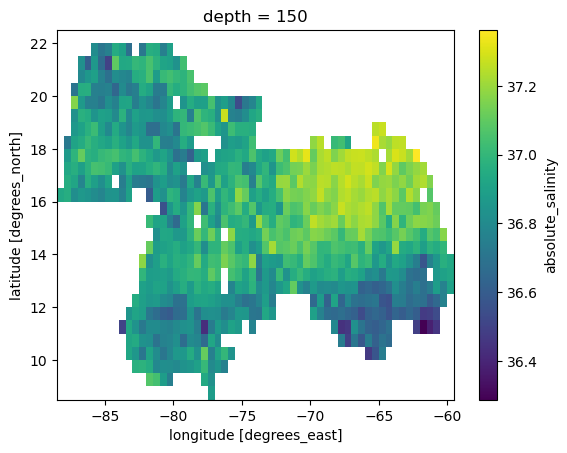

In [12]:
clim_mean_ds.absolute_salinity[22,:,:].plot()

## Specific loop for salinity maximum and respective number of profiles in each month in each decade

In [13]:
decades = np.arange(1910,2031,10)
months = np.arange(1,13)

mid_decades = (decades+5)[0:-1]

## Pull out depth index before loop
depth_ind = np.where((ds.depth>=100)&(ds.depth<=300))[0]

## Pre-allocate for monthly mean salinity maximum per decade
## Dimensions should be (longitude, latitude, month, decade)
seasonal_smw_mean = np.empty((len(months),len(decades)-1))
seasonal_smw_mean[:] = np.nan
seasonal_smw_obs_count = np.empty((len(months),len(decades)-1))
seasonal_smw_obs_count[:] = np.nan


for x in np.arange(0,len(decades)-1):
    subset_ds = ds.where((ds.depth>=100)&(ds.depth<=300)&(ds.time.dt.year>=decades[x])&(ds.time.dt.year<decades[x+1]),drop=True)
    
    smw_values = subset_ds.absolute_salinity.max(dim='depth').mean(dim=('longitude','latitude')).groupby(subset_ds.time.dt.month).mean().values
    smw_value_month_ind = subset_ds.absolute_salinity.max(dim='depth').mean(dim=('longitude','latitude')).groupby(subset_ds.time.dt.month).mean().month.values-1
    smw_count = subset_ds.num_profs[:,:,:,0].sum(dim=['latitude','longitude']).groupby(subset_ds.time.dt.month).sum().values
    smw_count_month_ind = subset_ds.num_profs[:,:,:,0].sum(dim=['latitude','longitude']).groupby(subset_ds.time.dt.month).sum().month.values-1
    
    seasonal_smw_mean[smw_value_month_ind,x] = smw_values
    seasonal_smw_obs_count[smw_count_month_ind,x] = smw_count
    

In [14]:
mid_decades

array([1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005, 2015,
       2025])

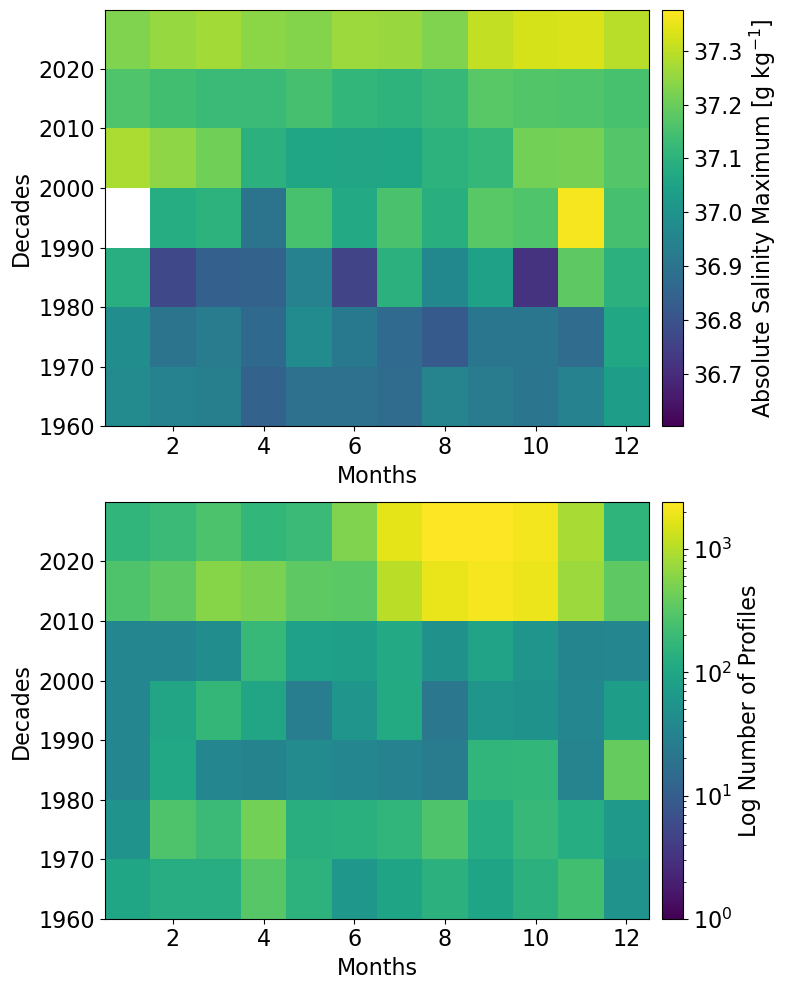

In [15]:
font_size = 16

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

im = axs[0].pcolormesh(months,mid_decades,seasonal_smw_mean.transpose())
clb = plt.colorbar(im,pad=0.02)
clb.ax.tick_params(labelsize=font_size) 
clb.set_label(label='Absolute Salinity Maximum [g kg$^{-1}$]',fontsize=font_size)



axs[0].set_ylim(1960,2029.9)
axs[0].set_ylabel('Decades',fontsize=font_size)
axs[0].set_xlabel('Months',fontsize=font_size)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)

im = axs[1].pcolormesh(months,mid_decades,seasonal_smw_obs_count.transpose(),norm=matplotlib.colors.LogNorm())
clb = plt.colorbar(im,pad=0.02)
clb.ax.tick_params(labelsize=font_size) 
clb.set_label(label='Log Number of Profiles',fontsize=font_size)

axs[1].set_ylim(1960,2029.9)
axs[1].set_ylabel('Decades',fontsize=font_size)
axs[1].set_xlabel('Months',fontsize=font_size)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)

fig.tight_layout()

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_Monthly_Decadal_SMW_Matrix.png',dpi=300,facecolor='white',bbox_inches='tight')


In [16]:
decades = np.arange(1910,2031,10)
months = np.arange(1,13)

mid_decades = (decades+5)[0:-1]


## Pre-allocate for monthly mean salinity maximum per decade
## Dimensions should be (longitude, latitude, month, decade)
seasonal_OHC_mean = np.empty((len(months),len(decades)-1))
seasonal_OHC_mean[:] = np.nan
seasonal_OHC_obs_count = np.empty((len(months),len(decades)-1))
seasonal_OHC_obs_count[:] = np.nan


for x in np.arange(0,len(decades)-1):
    subset_ds = ds.where((ds.time.dt.year>=decades[x])&(ds.time.dt.year<decades[x+1]),drop=True)
    subset_ds = subset_ds.groupby(subset_ds.time.dt.month).mean()
    
    
    OHC_values = np.empty((len(subset_ds.latitude),len(subset_ds.longitude),len(subset_ds.month)))
    OHC_values[:] = np.nan
    
    for a in np.arange(0,len(subset_ds.latitude.values)):
        for b in np.arange(0,len(ds.longitude.values)):
            for c in np.arange(0,len(subset_ds.month)):
                OHC_values[a,b,c] = ocean_heat_content(subset_ds.depth.values,subset_ds.conservative_temperature.values[c,:,a,b],subset_ds.potential_density.values[c,:,a,b])


    
    month_ind = subset_ds.month.values-1
    
    prof_count = subset_ds.num_profs.sum(dim=['latitude','longitude'])
    
    seasonal_OHC_mean[month_ind,x] = np.nanmean(OHC_values,axis=(0,1))
    seasonal_OHC_obs_count[month_ind,x] = prof_count
    

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:410: RuntimeWarning: All-NaN slice encountered
  min_temp = np.nanmin(temp)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/4006488668.py:34: RuntimeWarning: Mean of empty slice
  seasonal_OHC_mean[month_ind,x] = np.nanmean(OHC_values,axis=(0,1))
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:410: RuntimeWarning: All-NaN slice encountered
  min_temp = np.nanmin(temp)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/4006488668.py:34: RuntimeWarning: Mean of empty slice
  seasonal_OHC_mean[month_ind,x] = np.nanmean(OHC_values,axis=(0,1))
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:410: RuntimeWarning: All-NaN slice encountered
  min_temp = np.nanmin(temp)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:410: RuntimeWarning: All-NaN slice encountered
  min_temp = np.nanmin(temp)
/var/fol

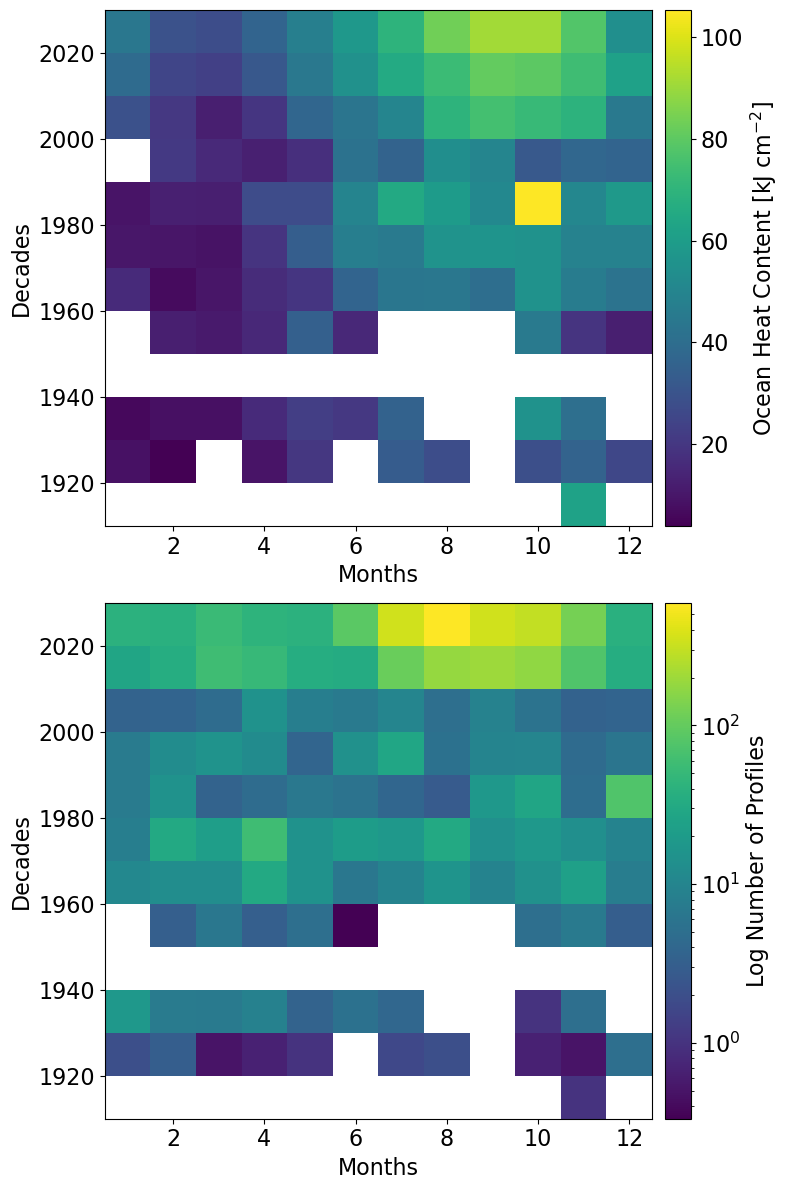

In [17]:
font_size = 16

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

im = axs[0].pcolormesh(months,mid_decades,seasonal_OHC_mean.transpose())
clb = plt.colorbar(im,pad=0.02)
clb.ax.tick_params(labelsize=font_size) 
clb.set_label(label='Ocean Heat Content [kJ cm$^{-2}$]',fontsize=font_size)


axs[0].set_ylabel('Decades',fontsize=font_size)
axs[0].set_xlabel('Months',fontsize=font_size)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)

im = axs[1].pcolormesh(months,mid_decades,seasonal_OHC_obs_count.transpose(),norm=matplotlib.colors.LogNorm())
clb = plt.colorbar(im,pad=0.02)
clb.ax.tick_params(labelsize=font_size) 
clb.set_label(label='Log Number of Profiles',fontsize=font_size)

axs[1].set_ylabel('Decades',fontsize=font_size)
axs[1].set_xlabel('Months',fontsize=font_size)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)

fig.tight_layout()

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_Monthly_Decadal_OHC_Matrix.png',dpi=300,facecolor='white',bbox_inches='tight')


## Now bulk decade calculations

### First do anomalies

In [18]:
## Calculate all/yearly anomalies
ds['salinity_anomaly'] = ds.absolute_salinity -clim_mean_ds.absolute_salinity
ds['temperature_anomaly'] = ds.conservative_temperature -clim_mean_ds.conservative_temperature
ds['density_anomaly'] = ds.potential_density -clim_mean_ds.potential_density

decades = np.arange(1910,2031,10)

## Pre-allocate for decadal anomaly
decadal_mean_salinity_anomaly = np.empty((ds['salinity_anomaly'].shape[0],ds['salinity_anomaly'].shape[1],ds['salinity_anomaly'].shape[2],len(decades)-1))
decadal_mean_salinity_anomaly[:] = np.nan
decadal_mean_temperature_anomaly = np.empty((ds['temperature_anomaly'].shape[0],ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_mean_temperature_anomaly[:] = np.nan
decadal_mean_density_anomaly = np.empty((ds['temperature_anomaly'].shape[0],ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_mean_density_anomaly[:] = np.nan
decadal_mean_temperature_anomaly_OHC = np.empty((ds['temperature_anomaly'].shape[0],ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_mean_temperature_anomaly_OHC[:] = np.nan
## Pre-allocate for decadal mean
decadal_mean_salinity = np.empty((ds['salinity_anomaly'].shape[0],ds['salinity_anomaly'].shape[1],ds['salinity_anomaly'].shape[2],len(decades)-1))
decadal_mean_salinity[:] = np.nan
decadal_mean_temperature = np.empty((ds['temperature_anomaly'].shape[0],ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_mean_temperature[:] = np.nan
decadal_mean_density = np.empty((ds['temperature_anomaly'].shape[0],ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_mean_density[:] = np.nan
decadal_mean_temperature_OHC = np.empty((ds['temperature_anomaly'].shape[0],ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_mean_temperature_OHC[:] = np.nan

decadal_OHC = np.empty((ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_OHC[:] = np.nan
decadal_OHC_num_profs = np.empty((len(decades)-1))
decadal_OHC_num_profs[:] = np.nan
decadal_PEA_200 = np.empty((ds['temperature_anomaly'].shape[1],ds['temperature_anomaly'].shape[2],len(decades)-1))
decadal_PEA_200[:] = np.nan

for x in np.arange(0,len(decades)-1):
    decade_ind = np.where((ds.time.dt.year>=decades[x])&(ds.time.dt.year<decades[x+1]))[0]

    decade_OHC_ind = np.where((ds.time.dt.year>=decades[x])&(ds.time.dt.year<decades[x+1])&(ds.time.dt.month>=6)&(ds.time.dt.month<=10))[0]
    
    ## Calculate decadal mean anomalies
    decadal_mean_salinity_anomaly[:,:,:,x] = np.nanmean(ds.salinity_anomaly[:,:,:,decade_ind], axis=3)
    decadal_mean_temperature_anomaly[:,:,:,x] = np.nanmean(ds.temperature_anomaly[:,:,:,decade_ind], axis=3)
    decadal_mean_density_anomaly[:,:,:,x] = np.nanmean(ds.density_anomaly[:,:,:,decade_ind], axis=3)
    decadal_mean_temperature_anomaly_OHC[:,:,:,x] = np.nanmean(ds.temperature_anomaly[:,:,:,decade_OHC_ind], axis=3)

    ## Now add total climatological spatial mean back in to get actual value
    decadal_mean_salinity[:,:,:,x] = decadal_mean_salinity_anomaly[:,:,:,x] + clim_mean_ds.absolute_salinity
    decadal_mean_temperature[:,:,:,x] = decadal_mean_temperature_anomaly[:,:,:,x] + clim_mean_ds.conservative_temperature
    decadal_mean_density[:,:,:,x] = decadal_mean_density_anomaly[:,:,:,x] + clim_mean_ds.potential_density
    decadal_mean_temperature_OHC[:,:,:,x] = decadal_mean_temperature_anomaly_OHC[:,:,:,x] + clim_mean_ds.conservative_temperature

    
    decadal_OHC_num_profs[x] = ds.num_profs[:,:,decade_OHC_ind].sum()

    for a in np.arange(0,len(ds.latitude.values)):
        for b in np.arange(0,len(ds.longitude.values)):
            decadal_OHC[a,b,x] = ocean_heat_content(ds.depth.values,decadal_mean_temperature_OHC[:,a,b,x],decadal_mean_density[:,a,b,x])
            decadal_PEA_200[a,b,x] = potential_energy_anomaly(ds.depth.values,decadal_mean_density[:,a,b,x],max_depth=200,min_depth=0)


decadal_mean_OHC = np.nanmean(decadal_OHC,axis=(0,1))
decadal_std_OHC = np.nanstd(decadal_OHC,axis=(0,1))
decadal_mean_PEA_200 = np.nanmean(decadal_PEA_200,axis=(0,1))
decadal_std_PEA_200 = np.nanstd(decadal_PEA_200,axis=(0,1))


depth_ind = np.where((ds.depth>=100)&(ds.depth<=300))[0]
decadal_mean_salinity_max = np.nanmean(np.nanmax(decadal_mean_salinity[depth_ind],axis=0),axis=(0,1))
decadal_std_salinity_max = np.nanstd(np.nanmax(decadal_mean_salinity[depth_ind],axis=0),axis=(0,1))



/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/441643376.py:40: RuntimeWarning: Mean of empty slice
  decadal_mean_salinity_anomaly[:,:,:,x] = np.nanmean(ds.salinity_anomaly[:,:,:,decade_ind], axis=3)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/441643376.py:41: RuntimeWarning: Mean of empty slice
  decadal_mean_temperature_anomaly[:,:,:,x] = np.nanmean(ds.temperature_anomaly[:,:,:,decade_ind], axis=3)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/441643376.py:42: RuntimeWarning: Mean of empty slice
  decadal_mean_density_anomaly[:,:,:,x] = np.nanmean(ds.density_anomaly[:,:,:,decade_ind], axis=3)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/441643376.py:43: RuntimeWarning: Mean of empty slice
  decadal_mean_temperature_anomaly_OHC[:,:,:,x] = np.nanmean(ds.temperature_anomaly[:,:,:,decade_OHC_ind], axis=3)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:410: RuntimeWarning: All-NaN

In [19]:
decadal_mean_PEA_200[-1]-decadal_mean_PEA_200[5]

123.55220833015744

In [20]:
decadal_mean_OHC[-1]-decadal_mean_OHC[5]

31.861217851900044

## Try trend on OHC per spatial grid cell

In [21]:
decadal_slope_ohc = np.empty((decadal_OHC.shape[0],decadal_OHC.shape[1]))
decadal_slope_ohc[:] = np.nan

for x in np.arange(0,decadal_OHC.shape[0]):
    for y in np.arange(0,decadal_OHC.shape[1]):
        nans = np.isfinite(decadal_OHC[x,y,:])
        if np.nansum(nans) > 1:
            nanind = np.where(nans==True)[0]
            decadal_slope_ohc[x,y] = linregress(decades[:-1][nanind], decadal_OHC[x,y,nanind])[0]





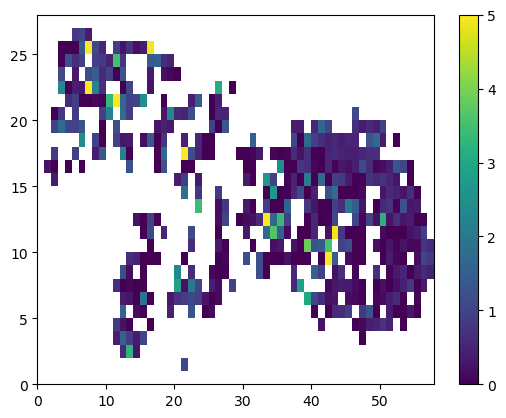

In [22]:
plt.pcolormesh(decadal_slope_ohc,vmin=0,vmax=5)
plt.colorbar()

In [23]:
np.nansum(decadal_slope_ohc>0)

386

In [24]:
386/(386+122)

0.7598425196850394

### Then do actual bulk decades

In [25]:
decadal_ds = ds.copy()
decadal_ds['time'] = (decadal_ds.time.dt.year//10)*10

depth_ind = np.where((decadal_ds.depth>=100)&(decadal_ds.depth<=300))[0]

decadal_smw = decadal_ds.absolute_salinity[depth_ind].max(dim='depth').mean(dim=['longitude','latitude']).groupby(decadal_ds.time).mean()
decadal_smw_std = decadal_ds.absolute_salinity[depth_ind].max(dim='depth').mean(dim=['longitude','latitude']).groupby(decadal_ds.time).std()



## Find number of obs per decades
decadal_obs_count = decadal_ds.num_profs.groupby(decadal_ds.time).sum()
## Replace zero values with nan for nicer plotting
decadal_obs_count = decadal_obs_count.where(decadal_obs_count != 0, np.nan)
decadal_SMW_count = decadal_obs_count.sum(dim=['longitude','latitude'])
## Boolean array for the lat lon points
decadal_obs_count_bool = decadal_obs_count.where(np.isnan(decadal_obs_count), 1).to_dataframe().reset_index().dropna()


## Investigating looking at different sub-basins
west_ds = decadal_ds.where(decadal_ds.longitude<-80,drop=True)
central_ds = decadal_ds.where((decadal_ds.longitude>-80)&(decadal_ds.longitude<-66),drop=True)
east_ds = decadal_ds.where(decadal_ds.longitude>-66,drop=True)

west_decadal_mean    = west_ds.mean(dim=['longitude','latitude']).absolute_salinity.groupby(west_ds.time).mean()
central_decadal_mean = central_ds.mean(dim=['longitude','latitude']).absolute_salinity.groupby(central_ds.time).mean()
east_decadal_mean    = east_ds.mean(dim=['longitude','latitude']).absolute_salinity.groupby(east_ds.time).mean()

## Yearly anomaly to mean

In [26]:
depth_ind = np.where((ds.depth>=100)&(ds.depth<=300))[0]

yearly_mean_salinity_anomaly = ds.salinity_anomaly.groupby(ds.time.dt.year).mean()+clim_mean_ds.absolute_salinity

yearly_mean_SMW = yearly_mean_salinity_anomaly[depth_ind].max(dim='depth').mean(dim=['longitude','latitude'])
yearly_SMW_std = yearly_mean_salinity_anomaly[depth_ind].max(dim='depth').std(dim=['longitude','latitude'])
yearly_SMW_count = ds.num_profs.sum(dim=['longitude','latitude']).groupby(ds.time.dt.year).sum()


## Different step here because just doing summer months for OHC

In [27]:

OHC_ds = ds.where((ds.time.dt.month>=6)&(ds.time.dt.month<=10),drop=True)

yearly_mean_temperature_anomaly = OHC_ds.temperature_anomaly.groupby(OHC_ds.time.dt.year).mean()+clim_mean_ds.conservative_temperature

yearly_mean_density = OHC_ds.density_anomaly.groupby(OHC_ds.time.dt.year).mean()+clim_mean_ds.potential_density

OHC_num_profs = OHC_ds.num_profs.sum(dim=['latitude','longitude']).groupby(OHC_ds.time.dt.year).sum()


## I don't understand why I randomly need to do this for loops to play nicely with dask
yearly_mean_temperature_anomaly = yearly_mean_temperature_anomaly.load()
yearly_mean_density = yearly_mean_density.load()

yearly_total_OHC = np.empty((len(ds.latitude.values),len(ds.longitude.values),len(yearly_mean_temperature_anomaly.year.values)))
yearly_total_OHC[:] = np.nan
                           

for x in np.arange(0,len(yearly_mean_temperature_anomaly.year.values)):
    for y in np.arange(0,len(ds.latitude.values)):
        for z in np.arange(0,len(ds.longitude.values)):
            yearly_total_OHC[y,z,x] = ocean_heat_content(ds.depth.values,yearly_mean_temperature_anomaly.values[:,y,z,x],yearly_mean_density.values[:,y,z,x])

yearly_mean_OHC = np.nanmean(yearly_total_OHC,axis=(0,1))
yearly_std_OHC  = np.nanstd(yearly_total_OHC,axis=(0,1))

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:410: RuntimeWarning: All-NaN slice encountered
  min_temp = np.nanmin(temp)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/2044011195.py:23: RuntimeWarning: Mean of empty slice
  yearly_mean_OHC = np.nanmean(yearly_total_OHC,axis=(0,1))
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Just yearly mean PEA here

In [28]:
yearly_mean_density_anomaly = ds.density_anomaly.groupby(ds.time.dt.year).mean()
yearly_mean_density = yearly_mean_density_anomaly+clim_mean_ds.potential_density



## I don't understand why I randomly need to do this for loops to play nicely with dask
yearly_mean_density = yearly_mean_density.load()


yearly_PEA_200 = np.empty((len(ds.latitude.values),len(ds.longitude.values),len(yearly_mean_density_anomaly.year.values)))
yearly_PEA_200[:] = np.nan
                           

for x in np.arange(0,len(yearly_mean_density_anomaly.year.year.values)):
    for y in np.arange(0,len(ds.latitude.values)):
        for z in np.arange(0,len(ds.longitude.values)):
            yearly_PEA_200[y,z,x] = potential_energy_anomaly(ds.depth.values,yearly_mean_density.values[:,y,z,x],max_depth=200,min_depth=0)


yearly_mean_PEA_200 = np.nanmean(yearly_PEA_200,axis=(0,1))
yearly_std_PEA_200  = np.nanstd(yearly_PEA_200,axis=(0,1))

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/985283246.py:487: RuntimeWarning: invalid value encountered in divide
  sigma = -1*z/max_depth
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/3339098364.py:20: RuntimeWarning: Mean of empty slice
  yearly_mean_PEA_200 = np.nanmean(yearly_PEA_200,axis=(0,1))
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Now calculate decadal mean profiles and Stats for trends at each depth layer for decadal temperature, salinity and density

In [29]:
ind = np.where(decades[:-1]>1959)[0]
plot_decades = decades[:-1][ind]



## These are with the anomalies removed and means added back in
decadal_mean_salinity_profile = np.nanmean(decadal_mean_salinity[:,:,:,ind],axis=(1,2))
decadal_salinity_profile_std = np.nanstd(decadal_mean_salinity[:,:,:,ind],axis=(1,2))
decadal_mean_temperature_profile = np.nanmean(decadal_mean_temperature[:,:,:,ind],axis=(1,2))
decadal_temperature_profile_std = np.nanstd(decadal_mean_temperature[:,:,:,ind],axis=(1,2))
decadal_mean_density_profile = np.nanmean(decadal_mean_density[:,:,:,ind],axis=(1,2))
decadal_density_profile_std = np.nanstd(decadal_mean_density[:,:,:,ind],axis=(1,2))




decadal_mean_salinity_profile_anomaly = decadal_mean_salinity_profile-np.tile(np.nanmean(decadal_mean_salinity_profile,axis=1),(len(plot_decades),1)).transpose()
decadal_mean_temperature_profile_anomaly = decadal_mean_temperature_profile-np.tile(np.nanmean(decadal_mean_temperature_profile,axis=1),(len(plot_decades),1)).transpose()


decadal_mean_salinity_profile_delta = decadal_mean_salinity_profile-np.tile(decadal_mean_salinity_profile[:,0],(len(plot_decades),1)).transpose()
decadal_mean_temperature_profile_delta = decadal_mean_temperature_profile-np.tile(decadal_mean_temperature_profile[:,0],(len(plot_decades),1)).transpose()
decadal_mean_density_profile_delta = decadal_mean_density_profile-np.tile(decadal_mean_density_profile[:,0],(len(plot_decades),1)).transpose()



ps = np.tile(gsw.p_from_z(-ds.depth,15),(len(plot_decades),1)).transpose()

decadal_mean_N2, p_N2 = gsw.stability.Nsquared(decadal_mean_salinity_profile, decadal_mean_temperature_profile, ps)
depthN2 = -gsw.z_from_p(p_N2,15)








decadal_slope_temp = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_slope_temp[:] = np.nan
decadal_intercept_temp = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_intercept_temp[:] = np.nan
decadal_r_temp = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_r_temp[:] = np.nan
decadal_p_temp = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_p_temp[:] = np.nan
decadal_e_temp = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_e_temp[:] = np.nan

decadal_slope_salt = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_slope_salt[:] = np.nan
decadal_intercept_salt = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_intercept_salt[:] = np.nan
decadal_r_salt = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_r_salt[:] = np.nan
decadal_p_salt = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_p_salt[:] = np.nan
decadal_e_salt = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_e_salt[:] = np.nan

decadal_slope_den = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_slope_den[:] = np.nan
decadal_intercept_den = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_intercept_den[:] = np.nan
decadal_r_den = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_r_den[:] = np.nan
decadal_p_den = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_p_den[:] = np.nan
decadal_e_den = np.empty((decadal_mean_salinity_profile.shape[0]))
decadal_e_den[:] = np.nan


decadal_slope_n2 = np.empty((decadal_mean_N2.shape[0]))
decadal_slope_n2[:] = np.nan
decadal_intercept_n2 = np.empty((decadal_mean_N2.shape[0]))
decadal_intercept_n2[:] = np.nan
decadal_r_n2 = np.empty((decadal_mean_N2.shape[0]))
decadal_r_n2[:] = np.nan
decadal_p_n2 = np.empty((decadal_mean_N2.shape[0]))
decadal_p_n2[:] = np.nan
decadal_e_n2 = np.empty((decadal_mean_N2.shape[0]))
decadal_e_n2[:] = np.nan


for x in np.arange(0,decadal_mean_salinity_profile.shape[0]):
    decadal_slope_temp[x], decadal_intercept_temp[x], decadal_r_temp[x], decadal_p_temp[x], decadal_e_temp[x] = linregress(plot_decades, decadal_mean_temperature_profile[x,:],alternative='greater') ## This checks if the positive slope is statistically significant
    decadal_slope_salt[x], decadal_intercept_salt[x], decadal_r_salt[x], decadal_p_salt[x], decadal_e_salt[x] = linregress(plot_decades, decadal_mean_salinity_profile[x,:],alternative='greater')
    decadal_slope_den[x], decadal_intercept_den[x], decadal_r_den[x], decadal_p_den[x], decadal_e_den[x] = linregress(plot_decades, decadal_mean_density_profile[x,:],alternative='less')


for x in np.arange(0,decadal_mean_N2.shape[0]):
    decadal_slope_n2[x], decadal_intercept_n2[x], decadal_r_n2[x], decadal_p_n2[x], decadal_e_n2[x] = linregress(plot_decades, decadal_mean_N2[x,:],alternative='greater')




/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1409883499.py:7: RuntimeWarning: Mean of empty slice
  decadal_mean_salinity_profile = np.nanmean(decadal_mean_salinity[:,:,:,ind],axis=(1,2))
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1409883499.py:9: RuntimeWarning: Mean of empty slice
  decadal_mean_temperature_profile = np.nanmean(decadal_mean_temperature[:,:,:,ind],axis=(1,2))
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1409883499.py:11: RuntimeWarning: Mean of empty slice
  decadal_mean_density_profile = np.nanmean(decadal_mean_density[:,:,:,ind],axis=(1,2))


## Testing a loop on the yearly mean salinity, temperature, and density to try to do the trends on only the non-nan values at each depth level

In [30]:
yearly_mean_salinity = ds.salinity_anomaly.groupby(ds.time.dt.year).mean()+clim_mean_ds.absolute_salinity
yearly_mean_temperature = ds.temperature_anomaly.groupby(ds.time.dt.year).mean()+clim_mean_ds.conservative_temperature
yearly_mean_density = ds.density_anomaly.groupby(ds.time.dt.year).mean()+clim_mean_ds.potential_density

yearly_mean_salinity_profile = yearly_mean_salinity.mean(dim=['latitude','longitude'])
yearly_mean_temperature_profile = yearly_mean_temperature.mean(dim=['latitude','longitude'])
yearly_mean_density_profile = yearly_mean_density.mean(dim=['latitude','longitude'])


salt_year_ind = np.where(np.sum(np.isfinite(yearly_mean_salinity_profile),axis=0) >= 42)[0] ## 42 is the index for 1000 m
temp_year_ind = np.where(np.sum(np.isfinite(yearly_mean_temperature_profile),axis=0) >= 42)[0] ## 42 is the index for 1000 m
den_year_ind = np.where(np.sum(np.isfinite(yearly_mean_density_profile),axis=0) >= 42)[0] ## 42 is the index for 1000 m

yearly_mean_salinity_profile = yearly_mean_salinity_profile[:,salt_year_ind]
yearly_mean_temperature_profile = yearly_mean_temperature_profile[:,temp_year_ind]
yearly_mean_density_profile = yearly_mean_density_profile[:,den_year_ind]

yearly_mean_salinity_profile = yearly_mean_salinity_profile.where(yearly_mean_salinity_profile.year>=1960,drop=True)
yearly_mean_temperature_profile = yearly_mean_temperature_profile.where(yearly_mean_temperature_profile.year>=1960,drop=True)
yearly_mean_density_profile = yearly_mean_density_profile.where(yearly_mean_density_profile.year>=1960,drop=True)

yearly_mean_salinity_profile = yearly_mean_salinity_profile.load()
yearly_mean_temperature_profile = yearly_mean_temperature_profile.load()
yearly_mean_density_profile = yearly_mean_density_profile.load()


# yearly_mean_salinity_profile = np.nanmean(yearly_mean_salinity,axis=(1,2))
# yearly_mean_temperature_profile = np.nanmean(yearly_mean_temperature,axis=(1,2))
# yearly_mean_density_profile = np.nanmean(yearly_mean_density,axis=(1,2))


salt_yrs = yearly_mean_salinity_profile.year.values
temp_yrs = yearly_mean_temperature_profile.year.values
den_yrs = yearly_mean_density_profile.year.values



ps = np.tile(gsw.p_from_z(-yearly_mean_density_profile.depth,15),(len(yearly_mean_density_profile.year),1)).transpose()
yearly_mean_N2, p_N2 = gsw.stability.Nsquared(yearly_mean_salinity_profile, yearly_mean_temperature_profile, ps)
depthN2 = -gsw.z_from_p(p_N2,15)




yearly_slope_temp = np.empty((yearly_mean_temperature_profile.shape[0]))
yearly_slope_temp[:] = np.nan
yearly_intercept_temp = np.empty((yearly_mean_temperature_profile.shape[0]))
yearly_intercept_temp[:] = np.nan
yearly_r_temp = np.empty((yearly_mean_temperature_profile.shape[0]))
yearly_r_temp[:] = np.nan
yearly_p_temp = np.empty((yearly_mean_temperature_profile.shape[0]))
yearly_p_temp[:] = np.nan
yearly_e_temp = np.empty((yearly_mean_temperature_profile.shape[0]))
yearly_e_temp[:] = np.nan

yearly_slope_salt = np.empty((yearly_mean_salinity_profile.shape[0]))
yearly_slope_salt[:] = np.nan
yearly_intercept_salt = np.empty((yearly_mean_salinity_profile.shape[0]))
yearly_intercept_salt[:] = np.nan
yearly_r_salt = np.empty((yearly_mean_salinity_profile.shape[0]))
yearly_r_salt[:] = np.nan
yearly_p_salt = np.empty((yearly_mean_salinity_profile.shape[0]))
yearly_p_salt[:] = np.nan
yearly_e_salt = np.empty((yearly_mean_salinity_profile.shape[0]))
yearly_e_salt[:] = np.nan

yearly_slope_den = np.empty((yearly_mean_density_profile.shape[0]))
yearly_slope_den[:] = np.nan
yearly_intercept_den = np.empty((yearly_mean_density_profile.shape[0]))
yearly_intercept_den[:] = np.nan
yearly_r_den = np.empty((yearly_mean_density_profile.shape[0]))
yearly_r_den[:] = np.nan
yearly_p_den = np.empty((yearly_mean_density_profile.shape[0]))
yearly_p_den[:] = np.nan
yearly_e_den = np.empty((yearly_mean_density_profile.shape[0]))
yearly_e_den[:] = np.nan

yearly_slope_n2 = np.empty((yearly_mean_N2.shape[0]))
yearly_slope_n2[:] = np.nan
yearly_intercept_n2 = np.empty((yearly_mean_N2.shape[0]))
yearly_intercept_n2[:] = np.nan
yearly_r_n2 = np.empty((yearly_mean_N2.shape[0]))
yearly_r_n2[:] = np.nan
yearly_p_n2 = np.empty((yearly_mean_N2.shape[0]))
yearly_p_n2[:] = np.nan
yearly_e_n2 = np.empty((yearly_mean_N2.shape[0]))
yearly_e_n2[:] = np.nan



for x in np.arange(0,decadal_mean_salinity_profile.shape[0]):
    salt_nan_ind = np.isfinite(yearly_mean_salinity_profile[x,:])    
    yearly_slope_salt[x], yearly_intercept_salt[x], yearly_r_salt[x], yearly_p_salt[x], yearly_e_salt[x] = linregress(salt_yrs[salt_nan_ind], yearly_mean_salinity_profile[x,salt_nan_ind])

for x in np.arange(0,yearly_mean_temperature_profile.shape[0]):
    temp_nan_ind = np.isfinite(yearly_mean_temperature_profile[x,:])
    yearly_slope_temp[x], yearly_intercept_temp[x], yearly_r_temp[x], yearly_p_temp[x], yearly_e_temp[x] = linregress(temp_yrs[temp_nan_ind], yearly_mean_temperature_profile[x,temp_nan_ind])

for x in np.arange(0,yearly_mean_density_profile.shape[0]):
    den_nan_ind = np.isfinite(yearly_mean_density_profile[x,:])
    yearly_slope_den[x], yearly_intercept_den[x], yearly_r_den[x], yearly_p_den[x], yearly_e_den[x] = linregress(den_yrs[den_nan_ind], yearly_mean_density_profile[x,den_nan_ind])

for x in np.arange(0,yearly_mean_N2.shape[0]):
    n2_nan_ind = np.isfinite(yearly_mean_N2[x,:])
    yearly_slope_n2[x], yearly_intercept_n2[x], yearly_r_n2[x], yearly_p_n2[x], yearly_e_n2[x] = linregress(den_yrs[n2_nan_ind], yearly_mean_N2[x,n2_nan_ind])



/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/3477600916.py:6: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = plt.contour(yearly_mean_temperature_profile.year,yearly_mean_temperature_profile.depth,yearly_mean_temperature_profile,[6,8,12,15,18,21,24,26,27,28],colors='black',linewidth=5)


<a list of 20 text.Text objects>

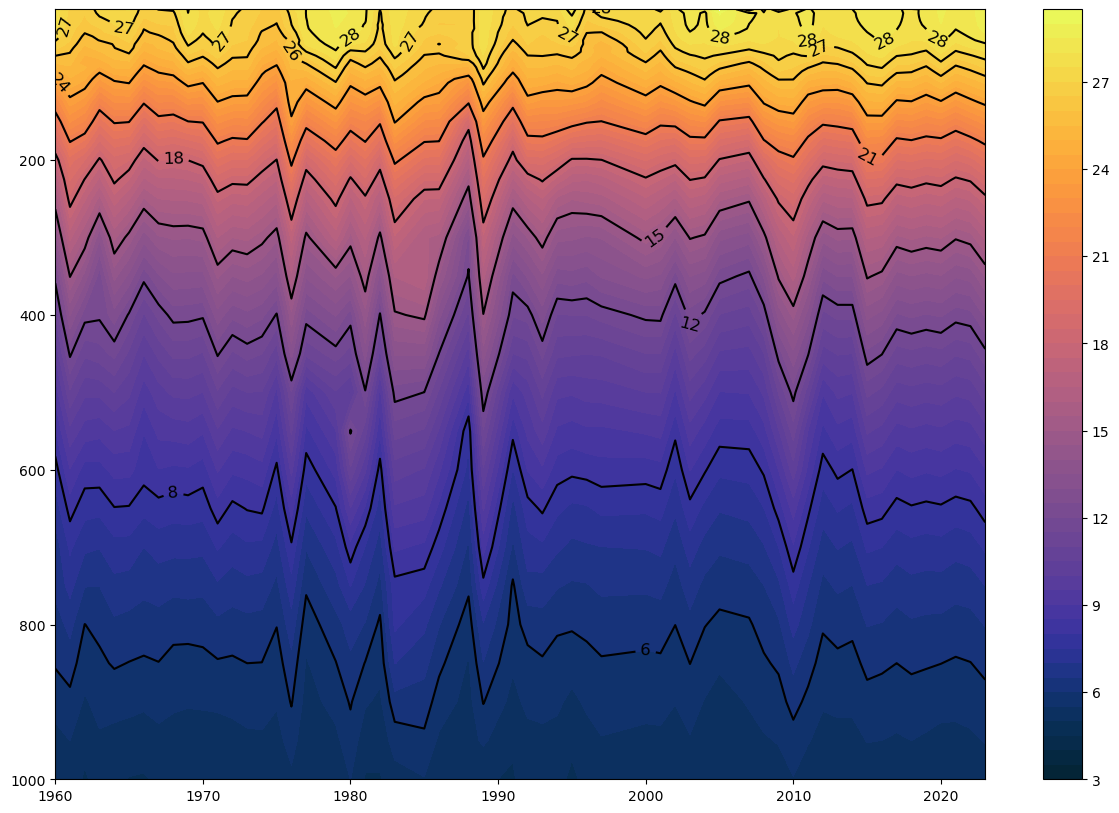

In [31]:
fontsize = 16
plt.figure(figsize=(15,10))
plt.contourf(yearly_mean_temperature_profile.year,yearly_mean_temperature_profile.depth,yearly_mean_temperature_profile,levels=np.arange(3,30,0.5),cmap=cmo.thermal)
plt.ylim(1000,5)
plt.colorbar()
cs = plt.contour(yearly_mean_temperature_profile.year,yearly_mean_temperature_profile.depth,yearly_mean_temperature_profile,[6,8,12,15,18,21,24,26,27,28],colors='black',linewidth=5)
plt.clabel(cs, inline=True, fontsize=fontsize-4)

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/3815102044.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = plt.contour(yearly_mean_salinity_profile.year,yearly_mean_salinity_profile.depth,yearly_mean_salinity_profile,[35,35.5,36,36.8,37,37.2],colors='black',linewidth=5)


<a list of 26 text.Text objects>

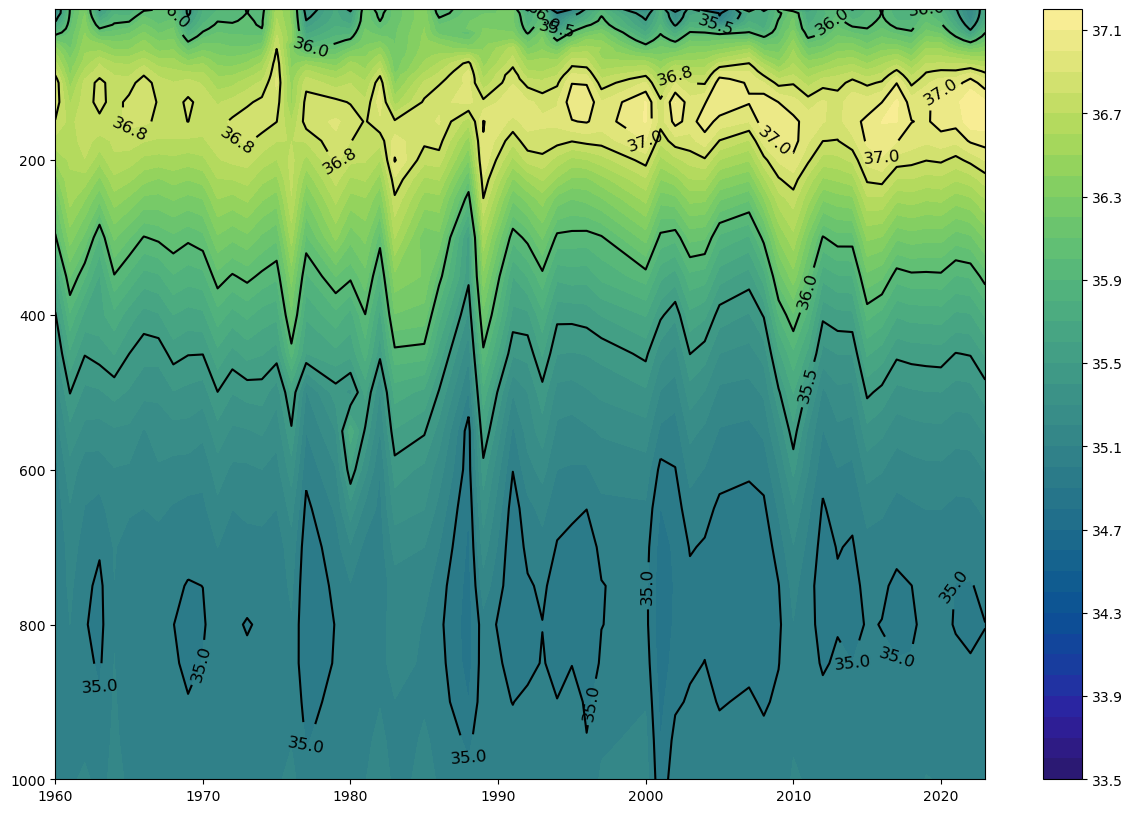

In [32]:
plt.figure(figsize=(15,10))
plt.contourf(yearly_mean_salinity_profile.year,yearly_mean_salinity_profile.depth,yearly_mean_salinity_profile,levels=np.arange(33.5,37.2,0.1),cmap=cmo.haline)
plt.ylim(1000,5)
plt.colorbar()
cs = plt.contour(yearly_mean_salinity_profile.year,yearly_mean_salinity_profile.depth,yearly_mean_salinity_profile,[35,35.5,36,36.8,37,37.2],colors='black',linewidth=5)
plt.clabel(cs, inline=True, fontsize=fontsize-4)


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/3588869167.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = plt.contour(yearly_mean_density_profile.year,yearly_mean_density_profile.depth,yearly_mean_density_profile,[1023,1024,1025,1026.25,1027,1027.25,1027.5],colors='white',linewidth=5)


<a list of 8 text.Text objects>

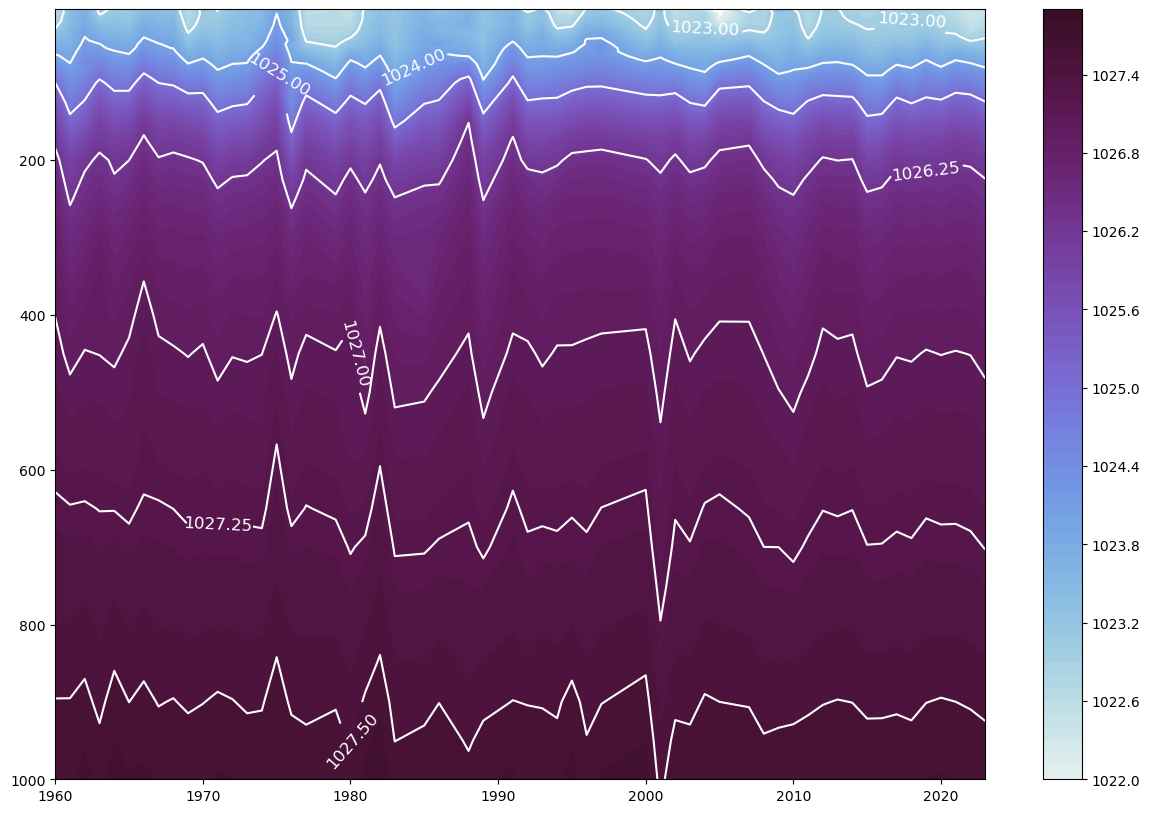

In [33]:
plt.figure(figsize=(15,10))
plt.contourf(yearly_mean_density_profile.year,yearly_mean_density_profile.depth,yearly_mean_density_profile,levels=np.arange(1022,1027.9,0.1),cmap=cmo.dense)
plt.ylim(1000,5)
plt.colorbar()
cs = plt.contour(yearly_mean_density_profile.year,yearly_mean_density_profile.depth,yearly_mean_density_profile,[1023,1024,1025,1026.25,1027,1027.25,1027.5],colors='white',linewidth=5)
plt.clabel(cs, inline=True, fontsize=fontsize-4)


In [34]:

ps = np.tile(gsw.p_from_z(-yearly_mean_density_profile.depth,15),(len(yearly_mean_density_profile.year),1)).transpose()

yearly_mean_N2, p_N2 = gsw.stability.Nsquared(yearly_mean_salinity_profile, yearly_mean_temperature_profile, ps)
depthN2 = -gsw.z_from_p(p_N2,15)

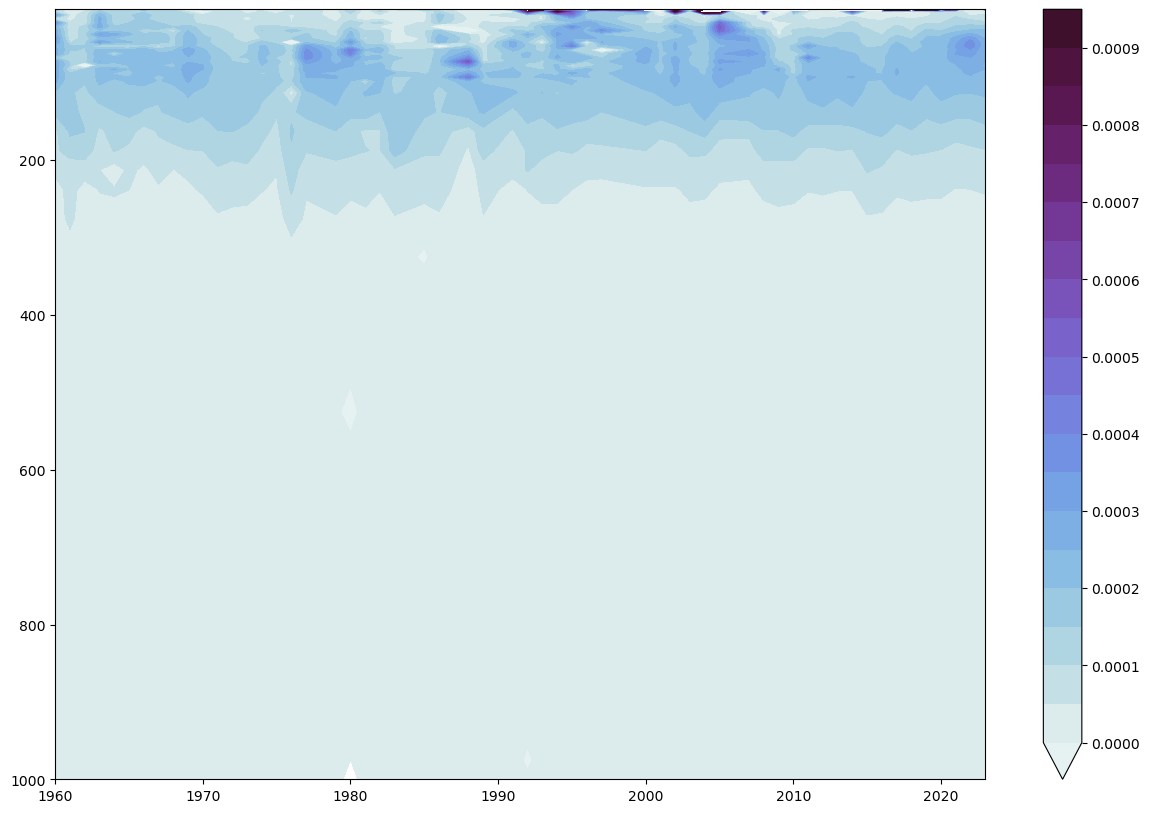

In [35]:
plt.figure(figsize=(15,10))
plt.contourf(yearly_mean_density_profile.year,depthN2[:,0],yearly_mean_N2,levels=np.arange(0,0.001,0.00005),cmap=cmo.dense,extend='min')
plt.ylim(1000,5)
plt.colorbar()
#cs = plt.contour(yearly_mean_density_profile.year,yearly_mean_density_profile.depth,yearly_mean_density_profile,[1023,1024,1025,1026.25,1027,1027.25,1027.5],colors='white',linewidth=5)
#plt.clabel(cs, inline=True, fontsize=fontsize-4)


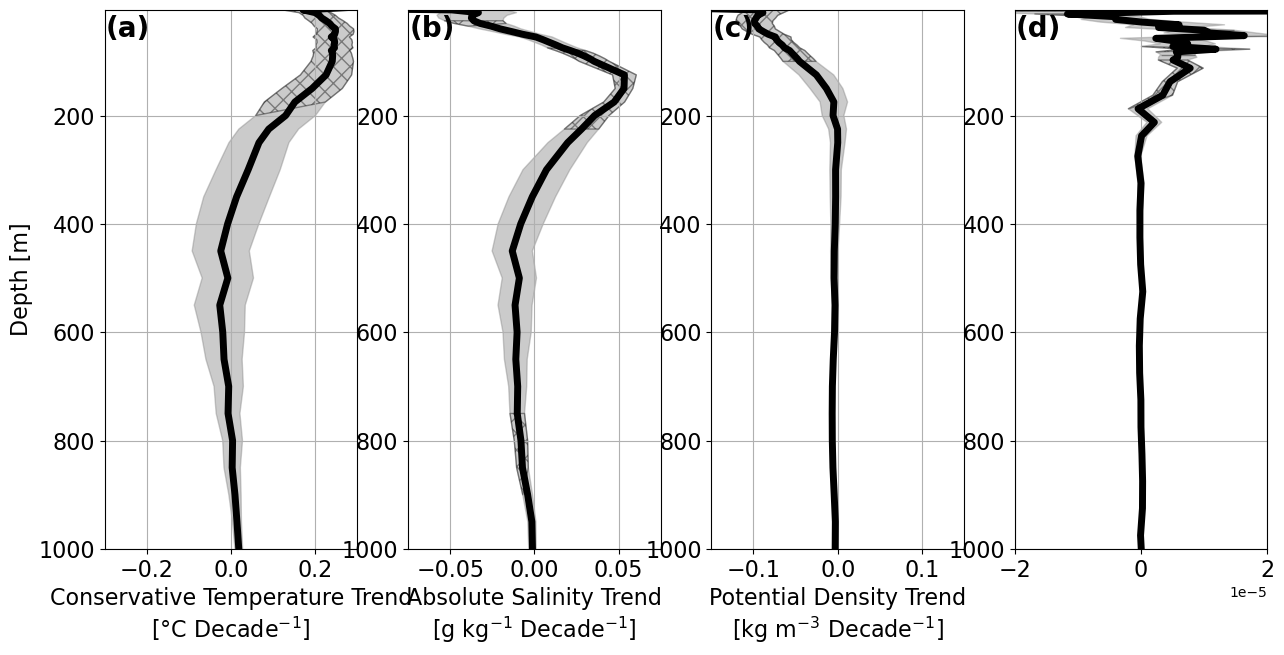

In [36]:
lwd = 3
font_size = 16
subplot_label_font_size = 20


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,7))


ax[0].plot(yearly_slope_temp*10,ds.depth,color='black',linewidth=5)
ax[0].fill_betweenx(ds.depth, yearly_slope_temp*10 - yearly_e_temp*10, yearly_slope_temp*10 + yearly_e_temp*10, color='tab:grey', alpha=0.4)
ax[0].fill_betweenx(ds.depth, yearly_slope_temp*10 - yearly_e_temp*10, yearly_slope_temp*10 + yearly_e_temp*10, 
                      where=yearly_p_temp<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[0].set_ylim(1000,5)
ax[0].set_xlim(-0.3,0.3)
ax[0].grid()
ax[0].set_ylabel('Depth [m]',fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].text(0.005,0.95,'(a)', transform=ax[0].transAxes, size=subplot_label_font_size, weight='bold')
#ax[0].xaxis.set_minor_locator(plt.MultipleLocator(0.5))  # Set minor ticks at every 0.1 interval
ax[0].set_xlabel('Conservative Temperature Trend\n[°C Decade$^{-1}$]',fontsize=font_size)


ax[1].plot(yearly_slope_salt*10,ds.depth,color='black',linewidth=5)
ax[1].fill_betweenx(ds.depth, yearly_slope_salt*10 - yearly_e_salt*10, yearly_slope_salt*10 + yearly_e_salt*10, color='tab:grey', alpha=0.4)
ax[1].fill_betweenx(ds.depth, yearly_slope_salt*10 - yearly_e_salt*10, yearly_slope_salt*10 + yearly_e_salt*10, 
                      where=yearly_p_salt<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[1].set_ylim(1000,5)
ax[1].set_xlim(-0.075,0.075)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].text(0.005,0.95,'(b)', transform=ax[1].transAxes, size=subplot_label_font_size, weight='bold')
#ax[1].xaxis.set_minor_locator(plt.MultipleLocator(0.25))  # Set minor ticks at every 0.1 interval
ax[1].set_xlabel('Absolute Salinity Trend\n[g kg$^{-1}$ Decade$^{-1}$]',fontsize=font_size)



ax[2].plot(yearly_slope_den*10,ds.depth,color='black',linewidth=5)
ax[2].fill_betweenx(ds.depth, yearly_slope_den*10 - yearly_e_den*10, yearly_slope_den*10 + yearly_e_den*10, color='tab:grey', alpha=0.4)
ax[2].fill_betweenx(ds.depth, yearly_slope_den*10 - yearly_e_den*10, yearly_slope_den*10 + yearly_e_den*10, 
                      where=yearly_p_den<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[2].set_ylim(1000,5)
ax[2].set_xlim(-0.15,0.15)
ax[2].grid()
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].text(0.005,0.95,'(c)', transform=ax[2].transAxes, size=subplot_label_font_size, weight='bold')
#ax[2].xaxis.set_minor_locator(plt.MultipleLocator(0.25))  # Set minor ticks at every 0.1 interval
ax[2].set_xlabel('Potential Density Trend\n[kg m$^{-3}$ Decade$^{-1}$]',fontsize=font_size)



ax[3].plot(yearly_slope_n2*10,depthN2[:,0],color='black',linewidth=5)
ax[3].fill_betweenx(depthN2[:,0], yearly_slope_n2*10 - yearly_e_n2*10, yearly_slope_n2*10 + yearly_e_n2*10, color='tab:grey', alpha=0.4)
ax[3].fill_betweenx(depthN2[:,0], yearly_slope_n2*10 - yearly_e_n2*10, yearly_slope_n2*10 + yearly_e_n2*10, 
                      where=yearly_p_n2<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[3].set_ylim(1000,5)
ax[3].set_xlim(-0.00002,0.00002)
ax[3].grid()
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].text(0.005,0.95,'(d)', transform=ax[3].transAxes, size=subplot_label_font_size, weight='bold')
#ax[3].xaxis.set_minor_locator(plt.MultipleLocator(0.25))  # Set minor ticks at every 0.1 interval
#ax[3].set_xlabel('Potential Density Trend\n[kg m$^{-3}$ Decade$^{-1}$]',fontsize=font_size)


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_EN4_Mean_Temp_Salt_Den_N2_Trends_Yearly.png',dpi=300,facecolor='white',bbox_inches='tight')




In [37]:
yearly_slope_temp[0:20]

array([0.02928385, 0.01705558, 0.01988801, 0.02092135, 0.02151249,
       0.02251394, 0.02339441, 0.0239467 , 0.02477046, 0.02476838,
       0.0245801 , 0.02376963, 0.02448245, 0.02459148, 0.02440166,
       0.02454303, 0.02378976, 0.02406685, 0.0240999 , 0.02405973])

In [38]:
yearly_slope_temp[1:].max()

0.024770464948436256

## Maps

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is depre

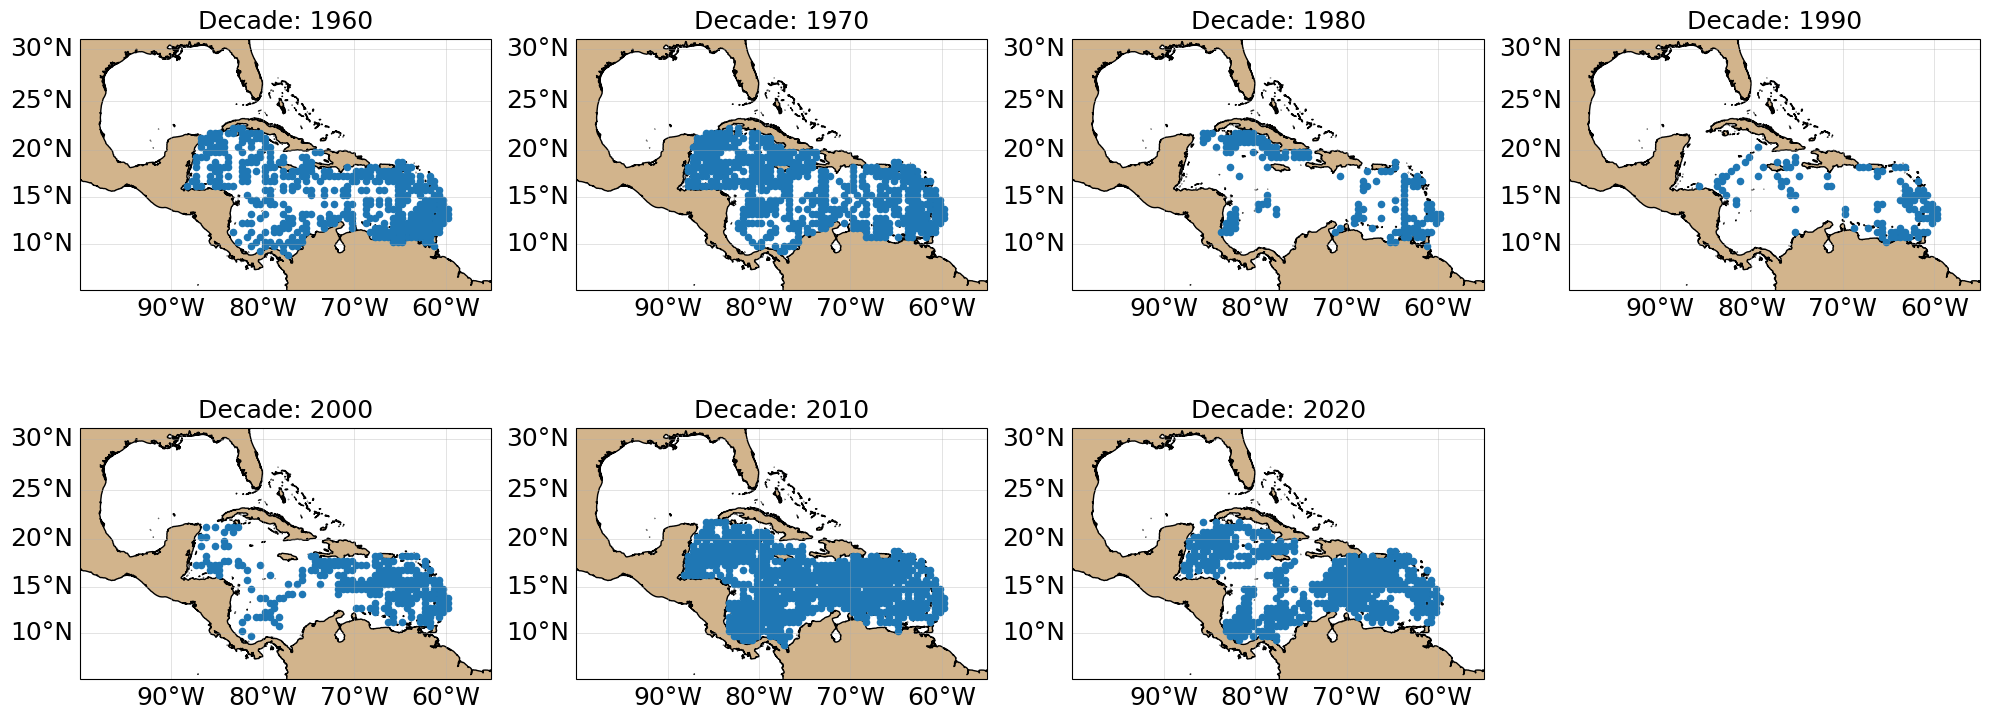

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8), subplot_kw=dict(projection=ccrs.Mercator()))

## Set lon and lat ranges
lon1 = -100
lon2 = -55
lat1 = 5
lat2 = 29

axs=axs.flatten()

start_ind=5
for x in np.arange(start_ind,len(decadal_obs_count.time)):
    axs_x = x-start_ind
    
    axs[axs_x].set_extent([lon1, lon2, lat1, lat2])

    LAND = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='black',
        facecolor='tan'
    )

    axs[axs_x].add_feature(LAND, zorder=0)

    glb = axs[axs_x].gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
    glb.xlabels_top = glb.ylabels_right = False
    glb.xlabel_style = {'size': 18}
    glb.ylabel_style = {'size': 18}
    
    #axs[axs_x].pcolormesh(decadal_obs_count.longitude,decadal_obs_count.latitude,decadal_obs_count.values[:,:,x],transform=ccrs.PlateCarree())
    
    subset_decadal_obs_count_bool = decadal_obs_count_bool.where(decadal_obs_count_bool.time==decadal_obs_count.time.values[x]).dropna()

    axs[axs_x].scatter(subset_decadal_obs_count_bool.longitude,subset_decadal_obs_count_bool.latitude,s=20,transform=ccrs.PlateCarree())
    axs[axs_x].set_title('Decade: %i'%decadal_obs_count.time[x], fontsize=18)


fig.delaxes(axs[7])
fig.tight_layout()


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_Decadal_Observations.png',dpi=300,facecolor='white',bbox_inches='tight')



In [40]:
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 12), subplot_kw=dict(projection=ccrs.Mercator()))

# ## Set lon and lat ranges
# lon1 = -100
# lon2 = -55
# lat1 = 5
# lat2 = 29

# axs=axs.flatten()

# start_ind=2
# for x in np.arange(start_ind,len(decadal_obs_count.time)):
#     axs_x = x-start_ind
    
#     axs[axs_x].set_extent([lon1, lon2, lat1, lat2])

#     LAND = cfeature.NaturalEarthFeature(
#         'physical', 'land', '10m',
#         edgecolor='black',
#         facecolor='tan'
#     )

#     axs[axs_x].add_feature(LAND, zorder=0)

#     glb = axs[axs_x].gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
#     glb.xlabels_top = glb.ylabels_right = False
#     glb.xlabel_style = {'size': 12}
#     glb.ylabel_style = {'size': 12}
    
#     im = axs[axs_x].pcolormesh(decadal_obs_count.longitude,decadal_obs_count.latitude,decadal_obs_count.values[:,:,x],transform=ccrs.PlateCarree(),vmin=0,vmax=50)
    


#     #subset_decadal_obs_count_bool = decadal_obs_count_bool.where(decadal_obs_count_bool.time==decadal_obs_count.time.values[x]).dropna()

#     #axs[axs_x].scatter(subset_decadal_obs_count_bool.longitude,subset_decadal_obs_count_bool.latitude,s=20,transform=ccrs.PlateCarree())
#     axs[axs_x].set_title('Decade: %i'%decadal_obs_count.time[x])



# # fig.subplots_adjust(right=0.8)
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# # fig.colorbar(im, cax=cbar_ax)


# clb = fig.colorbar(im,pad=0.02)
# clb.ax.tick_params(labelsize=16) 
# clb.set_label(label='Number of Observations',fontsize=16)


# fig.tight_layout()


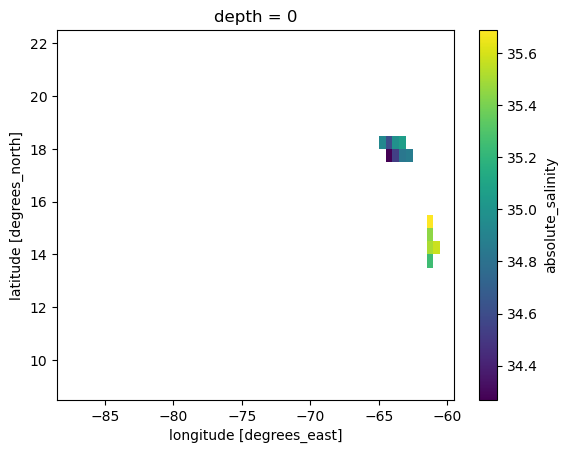

In [41]:
ds.absolute_salinity.where(ds.time.dt.year>=2020,drop=True).mean(dim='time')[0,:,:].plot()

In [42]:
ds

<xarray.Dataset>
Dimensions:                   (longitude: 58, latitude: 28, depth: 55, time: 825)
Coordinates:
  * longitude                 (longitude) float64 -88.25 -87.75 ... -59.75
  * latitude                  (latitude) float64 8.75 9.25 9.75 ... 21.75 22.25
  * depth                     (depth) int64 0 5 10 15 20 ... 1500 1550 1800 2050
  * time                      (time) datetime64[ns] 1914-02-01 ... 2023-11-01
Data variables:
    spatial_ref               (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    conservative_temperature  (depth, latitude, longitude, time) float64 nan ...
    absolute_salinity         (depth, latitude, longitude, time) float64 nan ...
    num_profs                 (latitude, longitude, time) float64 nan ... nan
    potential_density         (depth, latitude, longitude, time) float64 nan ...
    salinity_anomaly          (depth, latitude, longitude, time) float64 dask.array<chunksize=(55, 28, 58, 825), meta=np.ndarray>
    temperature_anomaly       (depth, latitude, longitude, time) float64 dask.array<chunksize=(55, 28, 58, 825), meta=np.ndarray>
    density_anomaly           (depth, latitude, longitude, time) float64 dask.array<chunksize=(55, 28, 58, 825), meta=np.ndarray>

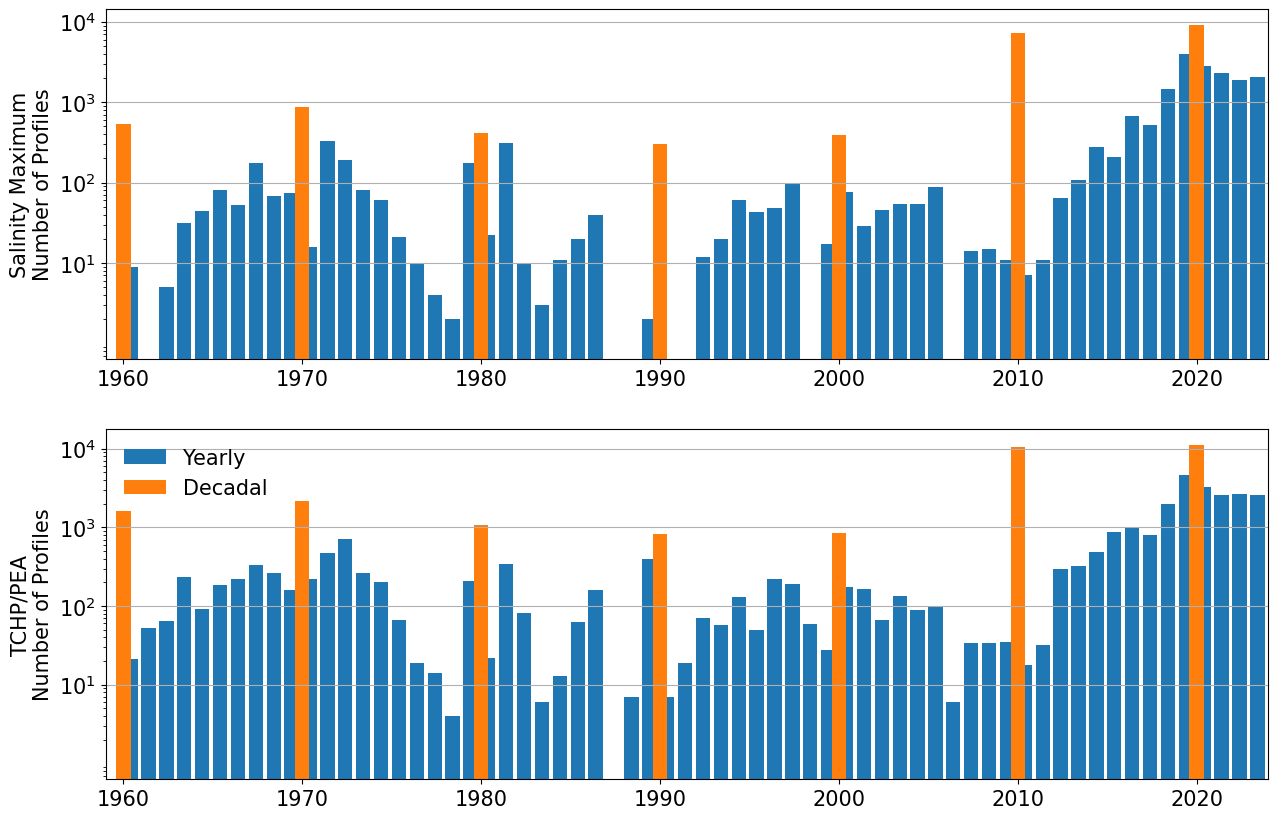

In [43]:
font_size=15
lwd=3
s=100

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

axs[0].bar(yearly_mean_temperature_anomaly.year.values,OHC_num_profs, align='edge',color='tab:blue')
axs[0].bar(decadal_smw.time.values,decadal_OHC_num_profs, align='center',color='tab:orange')
axs[0].set_ylabel('Salinity Maximum\nNumber of Profiles', fontsize=font_size)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].grid(axis='y')
axs[0].set_yscale('log')
axs[0].set_yticks([10,100, 1000,10000])
axs[0].set_xlim(1959,2024)


axs[1].bar(yearly_mean_SMW.year,yearly_SMW_count, align='edge',color='tab:blue',label='Yearly')
axs[1].bar(decadal_smw.time.values,decadal_SMW_count, align='center',color='tab:orange',label='Decadal')
axs[1].set_ylabel('TCHP/PEA\nNumber of Profiles', fontsize=font_size)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].grid(axis='y')
axs[1].set_yscale('log')
axs[1].set_yticks([10,100, 1000,10000])
axs[1].set_xlim(1959,2024)

axs[1].legend(loc='upper left',markerscale=1.5,frameon=False, fontsize=font_size)


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_EN4_OHC_SMW_Num_Obs.png',dpi=300,facecolor='white',bbox_inches='tight')


/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/dask/array/numpy_compat.py:51: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/joegradone/anaconda3/envs/r

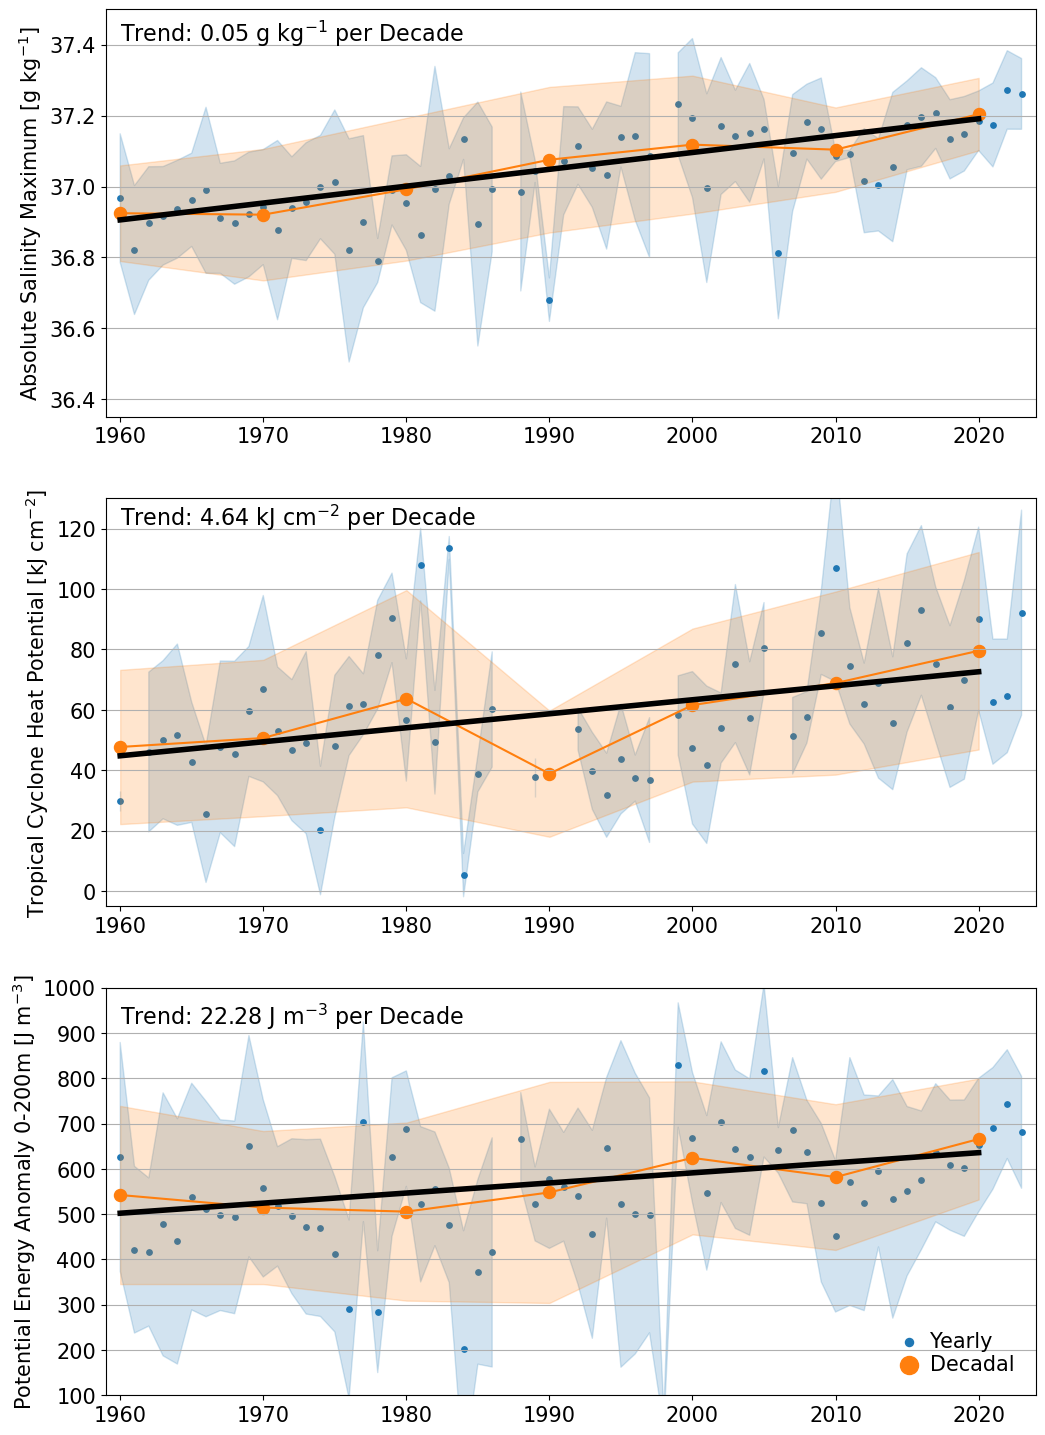

In [44]:
## For plotting and stats post 1950
ind = np.where(decades[:-1]>1959)[0]
decadal_OHC_plot = decadal_mean_OHC[ind]
decadal_OHC_std_plot  = decadal_std_OHC[ind]
plot_decades = decades[:-1][ind]


decadal_PEA_200_plot = decadal_mean_PEA_200[ind]
decadal_std_PEA_200_plot = decadal_std_PEA_200[ind]


decadal_smw_plot = decadal_mean_salinity_max[ind]
decadal_smw_std_plot  = decadal_std_salinity_max[ind]


## Stats
decadal_slope_OHC, decadal_intercept_OHC, decadal_r_OHC, decadal_p_OHC, decadal_e_OHC = linregress(plot_decades, decadal_OHC_plot)
decadal_trend_OHC = decadal_intercept_OHC + decadal_slope_OHC*plot_decades

## Stats
decadal_slope_smw, decadal_intercept_smw, decadal_r_smw, decadal_p_smw, decadal_e_smw = linregress(plot_decades, decadal_smw_plot)
decadal_trend_smw = decadal_intercept_smw + decadal_slope_smw*plot_decades

## Stats
decadal_slope_PEA, decadal_intercept_PEA, decadal_r_PEA, decadal_p_PEA, decadal_e_PEA = linregress(plot_decades, decadal_PEA_200_plot)
decadal_trend_PEA = decadal_intercept_PEA + decadal_slope_PEA*plot_decades






font_size=15
lwd=3
s=100

fig, axs = plt.subplots(3, 1, figsize=(12, 18))





##############################################################################################################################################
axs[0].scatter(yearly_mean_SMW.year,yearly_mean_SMW,s=15, color='tab:blue',label='Yearly')
axs[0].fill_between(yearly_mean_SMW.year, yearly_mean_SMW-yearly_SMW_std,yearly_mean_SMW+yearly_SMW_std, color='tab:blue',alpha=0.2)

axs[0].plot(plot_decades,decadal_smw_plot, color='tab:orange')
axs[0].scatter(decades[:-1],decadal_mean_salinity_max,s=75, color='tab:orange',label='Decadal')
axs[0].fill_between(plot_decades, decadal_smw_plot-decadal_smw_std_plot,decadal_smw_plot+decadal_smw_std_plot, color='tab:orange',alpha=0.2)


axs[0].plot(plot_decades,decadal_trend_smw,color='black',linewidth=lwd+1)

axs[0].grid(axis='y')
axs[0].set_ylim(36.35,37.5)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].set_ylabel('Absolute Salinity Maximum [g kg$^{-1}$]',fontsize=font_size)
axs[0].text(1960,37.41,'Trend: '+str(np.round(decadal_slope_smw*10,2))+' g kg$^{-1}$ per Decade',size=font_size+1,color='black')
axs[0].set_xlim(1959,2024)





##############################################################################################################################################
axs[1].scatter(yearly_mean_temperature_anomaly.year.values,yearly_mean_OHC,s=15, color='tab:blue',label='Yearly')
axs[1].fill_between(yearly_mean_temperature_anomaly.year.values, yearly_mean_OHC-yearly_std_OHC,yearly_mean_OHC+yearly_std_OHC, color='tab:blue',alpha=0.2)

axs[1].plot(plot_decades,decadal_OHC_plot, color='tab:orange')
axs[1].scatter(decades[:-1],decadal_mean_OHC,s=75, color='tab:orange',label='Decadal')
axs[1].fill_between(plot_decades, decadal_OHC_plot-decadal_OHC_std_plot,decadal_OHC_plot+decadal_OHC_std_plot, color='tab:orange',alpha=0.2)

axs[1].plot(plot_decades,decadal_trend_OHC,color='black',linewidth=lwd+1)

axs[1].grid(axis='y')
axs[1].set_ylim(-5,130)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].set_ylabel('Tropical Cyclone Heat Potential [kJ cm$^{-2}$]',fontsize=font_size)
axs[1].text(1960,121,'Trend: '+str(np.round(decadal_slope_OHC*10,2))+' kJ cm$^{-2}$ per Decade',size=font_size+1,color='black')
axs[1].set_xlim(1959,2024)






##############################################################################################################################################
axs[2].scatter(yearly_mean_density_anomaly.year,yearly_mean_PEA_200,s=15, color='tab:blue',label='Yearly')
axs[2].fill_between(yearly_mean_density_anomaly.year, yearly_mean_PEA_200-yearly_std_PEA_200,yearly_mean_PEA_200+yearly_std_PEA_200, color='tab:blue',alpha=0.2)

axs[2].plot(plot_decades,decadal_PEA_200_plot, color='tab:orange')
axs[2].scatter(decades[:-1],decadal_mean_PEA_200,s=75, color='tab:orange',label='Decadal')
axs[2].fill_between(plot_decades, decadal_PEA_200_plot-decadal_std_PEA_200_plot,decadal_PEA_200_plot+decadal_std_PEA_200_plot, color='tab:orange',alpha=0.2)
axs[2].legend(loc='lower right',markerscale=1.5,frameon=False, fontsize=font_size, labelspacing=0.15,borderaxespad=0.6,handletextpad=0.05)


axs[2].plot(plot_decades,decadal_trend_PEA,color='black',linewidth=lwd+1)

axs[2].grid(axis='y')
axs[2].set_ylim(100,1000)
axs[2].tick_params(axis='both', which='major', labelsize=font_size)
axs[2].set_ylabel('Potential Energy Anomaly 0-200m [J m$^{-3}$]',fontsize=font_size)
axs[2].text(1960,920,'Trend: '+str(np.round(decadal_slope_PEA*10,2))+' J m$^{-3}$ per Decade',size=font_size+1,color='black')
axs[2].set_xlim(1959,2024)




#plt.savefig('/Users/joegradone/Desktop/Caribbean_EN4_OHC_SMW_PEA_Trends.png',dpi=300,facecolor='white',bbox_inches='tight')


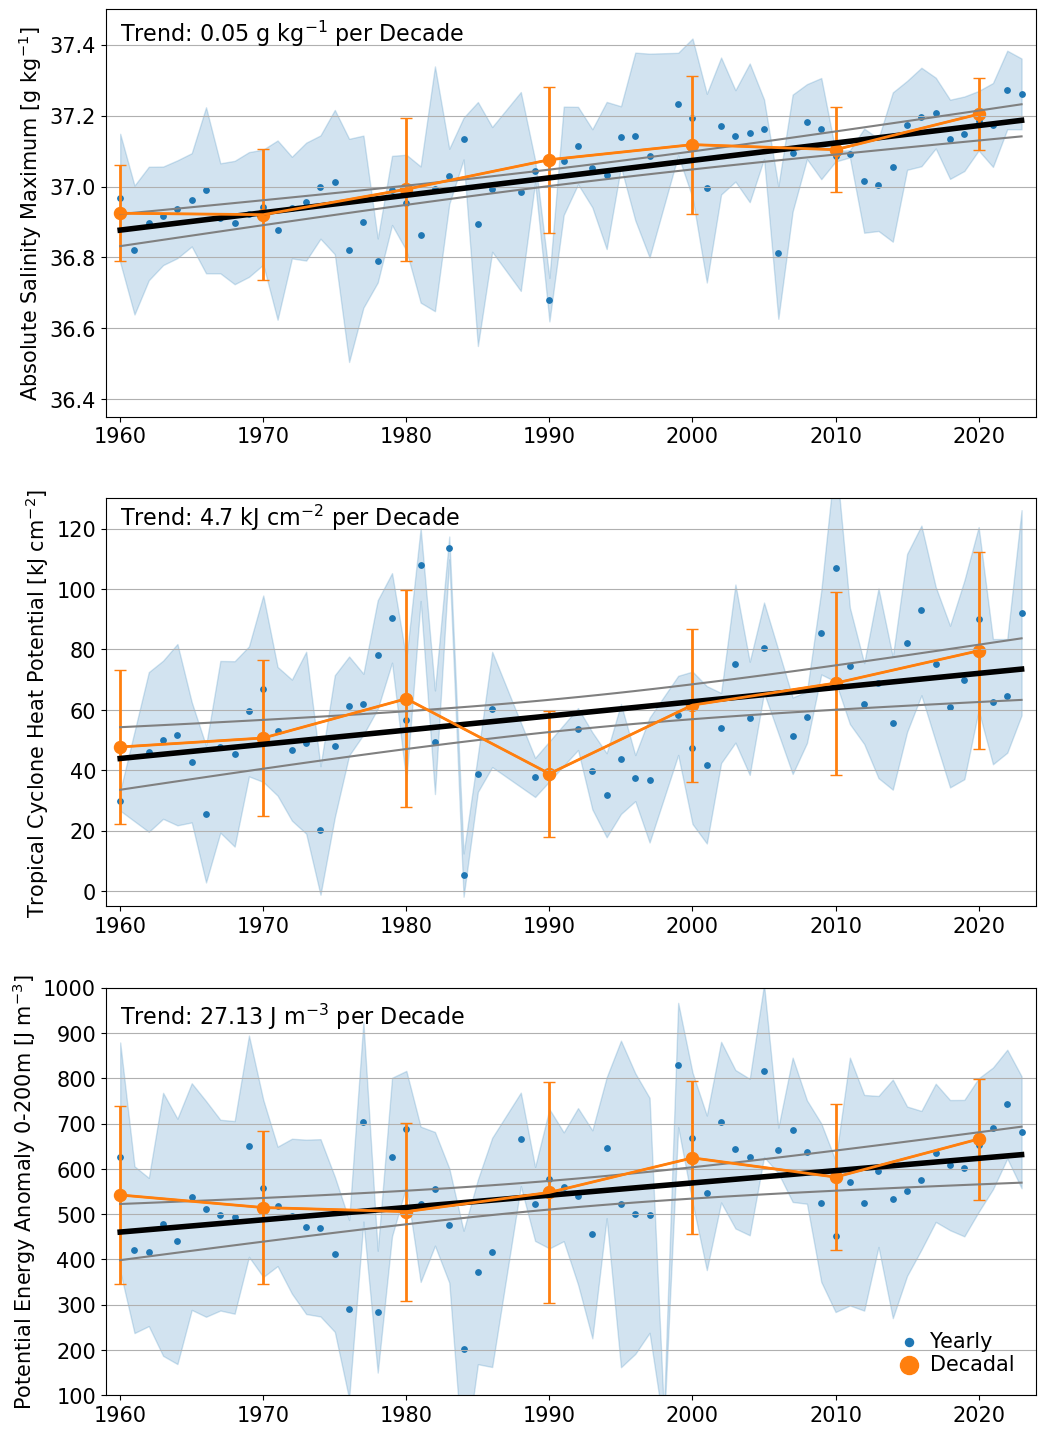

In [153]:
## For plotting and stats post 1950
ind = np.where(decades[:-1]>1959)[0]
decadal_OHC_plot = decadal_mean_OHC[ind]
decadal_OHC_std_plot  = decadal_std_OHC[ind]
plot_decades = decades[:-1][ind]
decadal_PEA_200_plot = decadal_mean_PEA_200[ind]
decadal_std_PEA_200_plot = decadal_std_PEA_200[ind]
decadal_smw_plot = decadal_mean_salinity_max[ind]
decadal_smw_std_plot  = decadal_std_salinity_max[ind]




## Subset to past 1960 and only non-nan
ind = np.where((yearly_mean_SMW.year>=1960) & (np.isfinite(yearly_mean_SMW.values)))[0]
SMW_years = yearly_mean_SMW.year[ind]
SMW = yearly_mean_SMW.values[ind]
SMW_std = yearly_SMW_std[ind]



ind = np.where((yearly_mean_temperature_anomaly.year>=1960) & (np.isfinite(yearly_mean_OHC)))[0]
OHC_years = yearly_mean_temperature_anomaly.year[ind]
OHC = yearly_mean_OHC[ind]
OHC_std = yearly_std_OHC[ind]




ind = np.where((yearly_mean_density_anomaly.year>=1960) & (np.isfinite(yearly_mean_PEA_200)))[0]
PEA_years = yearly_mean_density_anomaly.year[ind]
PEA = yearly_mean_PEA_200[ind]
PEA_std = yearly_std_PEA_200[ind]





## Stats
slope_OHC, intercept_OHC, r_OHC, p_OHC, e_OHC = linregress(OHC_years, OHC)
trend_OHC = intercept_OHC + slope_OHC*OHC_years

## Stats
slope_smw, intercept_smw, r_smw, p_smw, e_smw = linregress(SMW_years, SMW)
trend_smw = intercept_smw + slope_smw*SMW_years

## Stats
slope_PEA, intercept_PEA, r_PEA, p_PEA, e_PEA = linregress(PEA_years, PEA)
trend_PEA = intercept_PEA + slope_PEA*PEA_years






# Fit x to y
p_OHC, y_err_OHC = lin_fit(OHC_years.values, OHC)
# Calculate confidence intervals
p_x_OHC, confs_OHC = conf_calc(OHC_years.values, y_err_OHC, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_OHC, lower_OHC, upper_OHC = ylines_calc(p_x_OHC, confs_OHC, p_OHC)

# Fit x to y
p_smw, y_err_smw = lin_fit(SMW_years.values, SMW)
# Calculate confidence intervals
p_x_smw, confs_smw = conf_calc(SMW_years.values, y_err_smw, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_smw, lower_smw, upper_smw = ylines_calc(p_x_smw, confs_smw, p_smw)

# Fit x to y
p_PEA, y_err_PEA = lin_fit(PEA_years.values, PEA)
# Calculate confidence intervals
p_x_PEA, confs_PEA = conf_calc(PEA_years.values, y_err_PEA, 0.975)
# The fit line, and lower and upper confidence bounds
p_y_PEA, lower_PEA, upper_PEA = ylines_calc(p_x_PEA, confs_PEA, p_PEA)




font_size=15
lwd=3
s=100

fig, axs = plt.subplots(3, 1, figsize=(12, 18))





##############################################################################################################################################
axs[0].scatter(SMW_years,SMW,s=15, color='tab:blue',label='Yearly')
axs[0].fill_between(SMW_years, SMW-SMW_std,SMW+SMW_std, color='tab:blue',alpha=0.2)

axs[0].plot(plot_decades,decadal_smw_plot, color='tab:orange')
axs[0].scatter(decades[:-1],decadal_mean_salinity_max,s=75, color='tab:orange',label='Decadal')
axs[0].errorbar(plot_decades, decadal_smw_plot, yerr=decadal_smw_std_plot,color='tab:orange',capsize=4,linewidth=2)


axs[0].plot(SMW_years,trend_smw,color='black',linewidth=lwd+1)
# plot confidence limits
axs[0].plot(p_x_smw, lower_smw, color='grey')
axs[0].plot(p_x_smw, upper_smw, color='grey')

axs[0].grid(axis='y')
axs[0].set_ylim(36.35,37.5)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].set_ylabel('Absolute Salinity Maximum [g kg$^{-1}$]',fontsize=font_size)
axs[0].text(1960,37.41,'Trend: '+str(np.round(slope_smw*10,2))+' g kg$^{-1}$ per Decade',size=font_size+1,color='black')
axs[0].set_xlim(1959,2024)





##############################################################################################################################################
axs[1].scatter(OHC_years,OHC,s=15, color='tab:blue',label='Yearly')
axs[1].fill_between(OHC_years, OHC-OHC_std,OHC+OHC_std, color='tab:blue',alpha=0.2)

axs[1].plot(plot_decades,decadal_OHC_plot, color='tab:orange')
axs[1].scatter(decades[:-1],decadal_mean_OHC,s=75, color='tab:orange',label='Decadal')
axs[1].errorbar(plot_decades, decadal_OHC_plot, yerr=decadal_OHC_std_plot,color='tab:orange',capsize=4,linewidth=2)


axs[1].plot(OHC_years,trend_OHC,color='black',linewidth=lwd+1)
# plot confidence limits
axs[1].plot(p_x_OHC, lower_OHC, color='grey')
axs[1].plot(p_x_OHC, upper_OHC, color='grey')


axs[1].grid(axis='y')
axs[1].set_ylim(-5,130)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].set_ylabel('Tropical Cyclone Heat Potential [kJ cm$^{-2}$]',fontsize=font_size)
axs[1].text(1960,121,'Trend: '+str(np.round(slope_OHC*10,2))+' kJ cm$^{-2}$ per Decade',size=font_size+1,color='black')
axs[1].set_xlim(1959,2024)






##############################################################################################################################################
axs[2].scatter(PEA_years,PEA,s=15, color='tab:blue',label='Yearly')
axs[2].fill_between(PEA_years, PEA-PEA_std,PEA+PEA_std, color='tab:blue',alpha=0.2)

axs[2].plot(plot_decades,decadal_PEA_200_plot, color='tab:orange')
axs[2].scatter(decades[:-1],decadal_mean_PEA_200,s=75, color='tab:orange',label='Decadal')
axs[2].errorbar(plot_decades, decadal_PEA_200_plot, yerr=decadal_std_PEA_200_plot,color='tab:orange',capsize=4,linewidth=2)

axs[2].plot(PEA_years,trend_PEA,color='black',linewidth=lwd+1)
# plot confidence limits
axs[2].plot(p_x_PEA, lower_PEA, color='grey')
axs[2].plot(p_x_PEA, upper_PEA, color='grey')


axs[2].legend(loc='lower right',markerscale=1.5,frameon=False, fontsize=font_size, labelspacing=0.15,borderaxespad=0.6,handletextpad=0.05)
axs[2].grid(axis='y')
axs[2].set_ylim(100,1000)
axs[2].tick_params(axis='both', which='major', labelsize=font_size)
axs[2].set_ylabel('Potential Energy Anomaly 0-200m [J m$^{-3}$]',fontsize=font_size)
axs[2].text(1960,920,'Trend: '+str(np.round(slope_PEA*10,2))+' J m$^{-3}$ per Decade',size=font_size+1,color='black')
axs[2].set_xlim(1959,2024)




plt.savefig('/Users/joegradone/Desktop/Caribbean_EN4_OHC_SMW_PEA_Trends.png',dpi=300,facecolor='white',bbox_inches='tight')


In [154]:
np.nanmean(decadal_e_temp[0:32])*10

0.0635751060634522

In [155]:
sig_depth_ind_den  = np.where(decadal_p_den<0.05)[0]
sig_depth_ind_temp = np.where(decadal_p_temp<0.05)[0]
sig_depth_ind_salt = np.where(decadal_p_salt<0.05)[0]

In [156]:
ds.depth[sig_depth_ind_salt]

<xarray.DataArray 'depth' (depth: 12)>
array([ 70,  75,  80,  85,  90,  95, 100, 125, 150, 175, 200, 225])
Coordinates:
  * depth    (depth) int64 70 75 80 85 90 95 100 125 150 175 200 225

In [157]:
np.nanmean(decadal_slope_temp[40:42]*10)

0.022164839942311172

In [158]:
10**(-2)

0.01

In [159]:
decadal_slope_temp[40:42]*10

array([0.0198886 , 0.02444108])

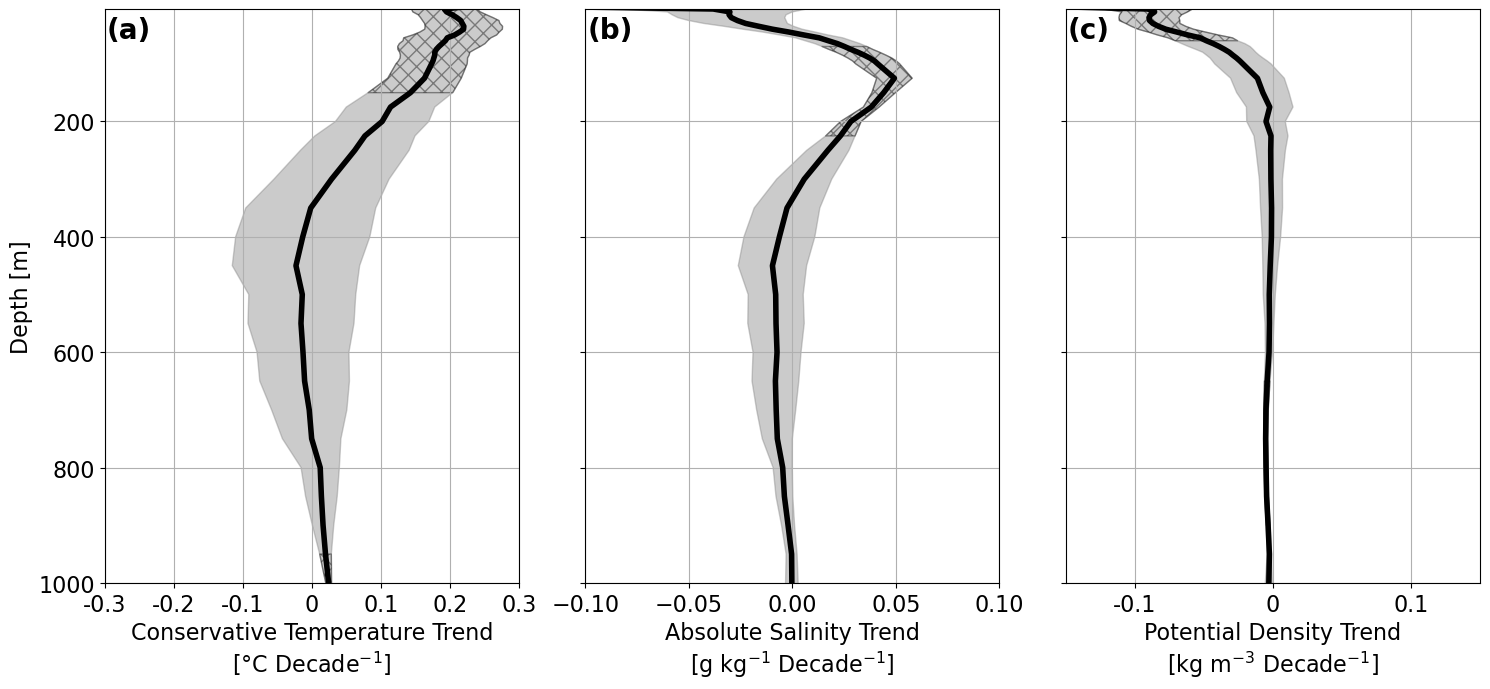

In [160]:
lwd = 3
font_size = 16
subplot_label_font_size = 20


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,7))


ax[0].plot(decadal_slope_temp*10,ds.depth,color='black',linewidth=4)
ax[0].fill_betweenx(ds.depth, decadal_slope_temp*10 - decadal_e_temp*10, decadal_slope_temp*10 + decadal_e_temp*10, color='tab:grey', alpha=0.4)
ax[0].fill_betweenx(ds.depth, decadal_slope_temp*10 - decadal_e_temp*10, decadal_slope_temp*10 + decadal_e_temp*10, 
                      where=decadal_p_temp<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[0].set_ylim(1000,5)
ax[0].set_xlim(-0.3,0.3)
ax[0].grid()
ax[0].set_ylabel('Depth [m]',fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].text(0.005,0.95,'(a)', transform=ax[0].transAxes, size=subplot_label_font_size, weight='bold')
ax[0].set_xlabel('Conservative Temperature Trend\n[°C Decade$^{-1}$]',fontsize=font_size)
ax[0].set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
ax[0].set_xticklabels([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


ax[1].plot(decadal_slope_salt*10,ds.depth,color='black',linewidth=4)
ax[1].fill_betweenx(ds.depth, decadal_slope_salt*10 - decadal_e_salt*10, decadal_slope_salt*10 + decadal_e_salt*10, color='tab:grey', alpha=0.4)
ax[1].fill_betweenx(ds.depth, decadal_slope_salt*10 - decadal_e_salt*10, decadal_slope_salt*10 + decadal_e_salt*10, 
                      where=decadal_p_salt<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[1].set_ylim(1000,5)
ax[1].set_xlim(-0.1,0.1)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].text(0.005,0.95,'(b)', transform=ax[1].transAxes, size=subplot_label_font_size, weight='bold')
ax[1].set_xlabel('Absolute Salinity Trend\n[g kg$^{-1}$ Decade$^{-1}$]',fontsize=font_size)
ax[1].set_yticklabels('')


ax[2].plot(decadal_slope_den*10,ds.depth,color='black',linewidth=4)
ax[2].fill_betweenx(ds.depth, decadal_slope_den*10 - decadal_e_den*10, decadal_slope_den*10 + decadal_e_den*10, color='tab:grey', alpha=0.4)
ax[2].fill_betweenx(ds.depth, decadal_slope_den*10 - decadal_e_den*10, decadal_slope_den*10 + decadal_e_den*10, 
                      where=decadal_p_den<=0.05,hatch='xx', alpha=0.4,facecolor="none", interpolate=True)
ax[2].set_ylim(1000,5)
ax[2].set_xlim(-0.15,0.15)
ax[2].grid()
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].text(0.005,0.95,'(c)', transform=ax[2].transAxes, size=subplot_label_font_size, weight='bold')
ax[2].set_xlabel('Potential Density Trend\n[kg m$^{-3}$ Decade$^{-1}$]',fontsize=font_size)
ax[2].set_yticklabels('')
ax[2].set_xticks([-0.1,0,0.1,])
ax[2].set_xticklabels([-0.1,0,0.1])

fig.tight_layout()

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_EN4_Mean_Temp_Salt_Den_Trends.png',dpi=300,facecolor='white',bbox_inches='tight')




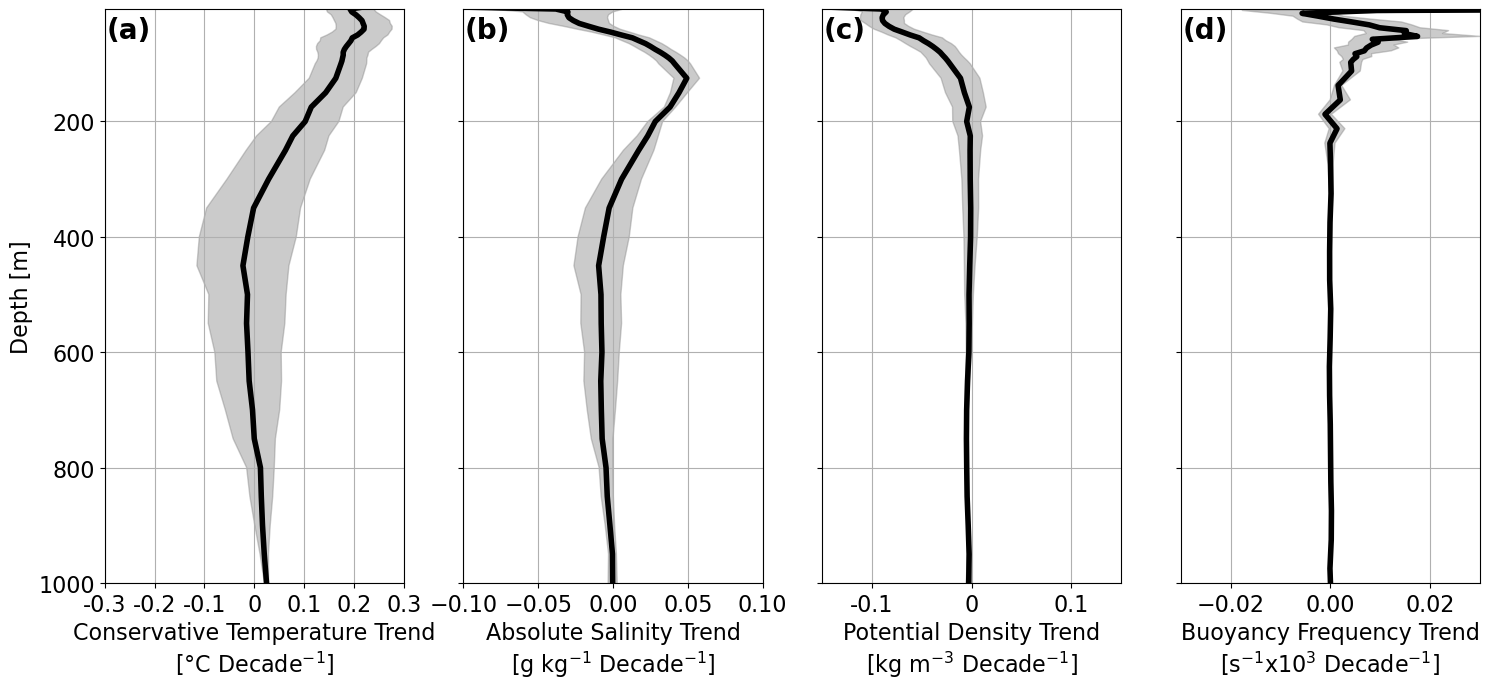

In [161]:
lwd = 3
font_size = 16
subplot_label_font_size = 20


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,7))


ax[0].plot(decadal_slope_temp*10,ds.depth,color='black',linewidth=4)
ax[0].fill_betweenx(ds.depth, decadal_slope_temp*10 - decadal_e_temp*10, decadal_slope_temp*10 + decadal_e_temp*10, color='tab:grey', alpha=0.4)
ax[0].set_ylim(1000,5)
ax[0].set_xlim(-0.3,0.3)
ax[0].grid()
ax[0].set_ylabel('Depth [m]',fontsize=font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].text(0.005,0.95,'(a)', transform=ax[0].transAxes, size=subplot_label_font_size, weight='bold')
ax[0].set_xlabel('Conservative Temperature Trend\n[°C Decade$^{-1}$]',fontsize=font_size)
ax[0].set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
ax[0].set_xticklabels([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


ax[1].plot(decadal_slope_salt*10,ds.depth,color='black',linewidth=4)
ax[1].fill_betweenx(ds.depth, decadal_slope_salt*10 - decadal_e_salt*10, decadal_slope_salt*10 + decadal_e_salt*10, color='tab:grey', alpha=0.4)
ax[1].set_ylim(1000,5)
ax[1].set_xlim(-0.1,0.1)
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].text(0.005,0.95,'(b)', transform=ax[1].transAxes, size=subplot_label_font_size, weight='bold')
ax[1].set_xlabel('Absolute Salinity Trend\n[g kg$^{-1}$ Decade$^{-1}$]',fontsize=font_size)
ax[1].set_yticklabels('')


ax[2].plot(decadal_slope_den*10,ds.depth,color='black',linewidth=4)
ax[2].fill_betweenx(ds.depth, decadal_slope_den*10 - decadal_e_den*10, decadal_slope_den*10 + decadal_e_den*10, color='tab:grey', alpha=0.4)
ax[2].set_ylim(1000,5)
ax[2].set_xlim(-0.15,0.15)
ax[2].grid()
ax[2].tick_params(axis='both', which='major', labelsize=font_size)
ax[2].text(0.005,0.95,'(c)', transform=ax[2].transAxes, size=subplot_label_font_size, weight='bold')
ax[2].set_xlabel('Potential Density Trend\n[kg m$^{-3}$ Decade$^{-1}$]',fontsize=font_size)
ax[2].set_yticklabels('')
ax[2].set_xticks([-0.1,0,0.1,])
ax[2].set_xticklabels([-0.1,0,0.1])




ax[3].plot(decadal_slope_n2*10*(10**3),depthN2[:,0],color='black',linewidth=4)
ax[3].fill_betweenx(depthN2[:,0], decadal_slope_n2*10*(10**3) - decadal_e_n2*10*(10**3), decadal_slope_n2*10*(10**3) + decadal_e_n2*10*(10**3), color='tab:grey', alpha=0.4)
ax[3].set_ylim(1000,5)
ax[3].set_xlim(-0.03,0.03)
ax[3].grid()
ax[3].tick_params(axis='both', which='major', labelsize=font_size)
ax[3].text(0.005,0.95,'(d)', transform=ax[3].transAxes, size=subplot_label_font_size, weight='bold')
ax[3].set_xlabel('Buoyancy Frequency Trend\n[s$^{-1}$x10$^{3}$ Decade$^{-1}$]',fontsize=font_size)
ax[3].set_yticklabels('')
#ax[3].set_xticks([-0.1,0,0.1,])
#ax[3].set_xticklabels([-0.1,0,0.1])

fig.tight_layout()

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/Caribbean_EN4_Mean_Temp_Salt_Den_N2_Trends.png',dpi=300,facecolor='white',bbox_inches='tight')




## Mean profiles over time

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1385194658.py:13: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax[0,0].contour(plot_decades,ds.depth,decadal_mean_temperature_profile,[6,10,14,18,22,26,27,28],colors='black',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1385194658.py:22: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax[0,1].contour(plot_decades,ds.depth,decadal_mean_salinity_profile,[35,35.5,36,36.5,36.7,36.8,36.9,37],colors='black',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1385194658.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax[0,2].contour(plot_decades,ds.depth,decadal_mean_density_profile,[1023,1024.5,1026.3,1026.8,1027.1,1027.5],colors='white',linewidth=5)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1385194658.py:40: UserWarning: The following kwargs were

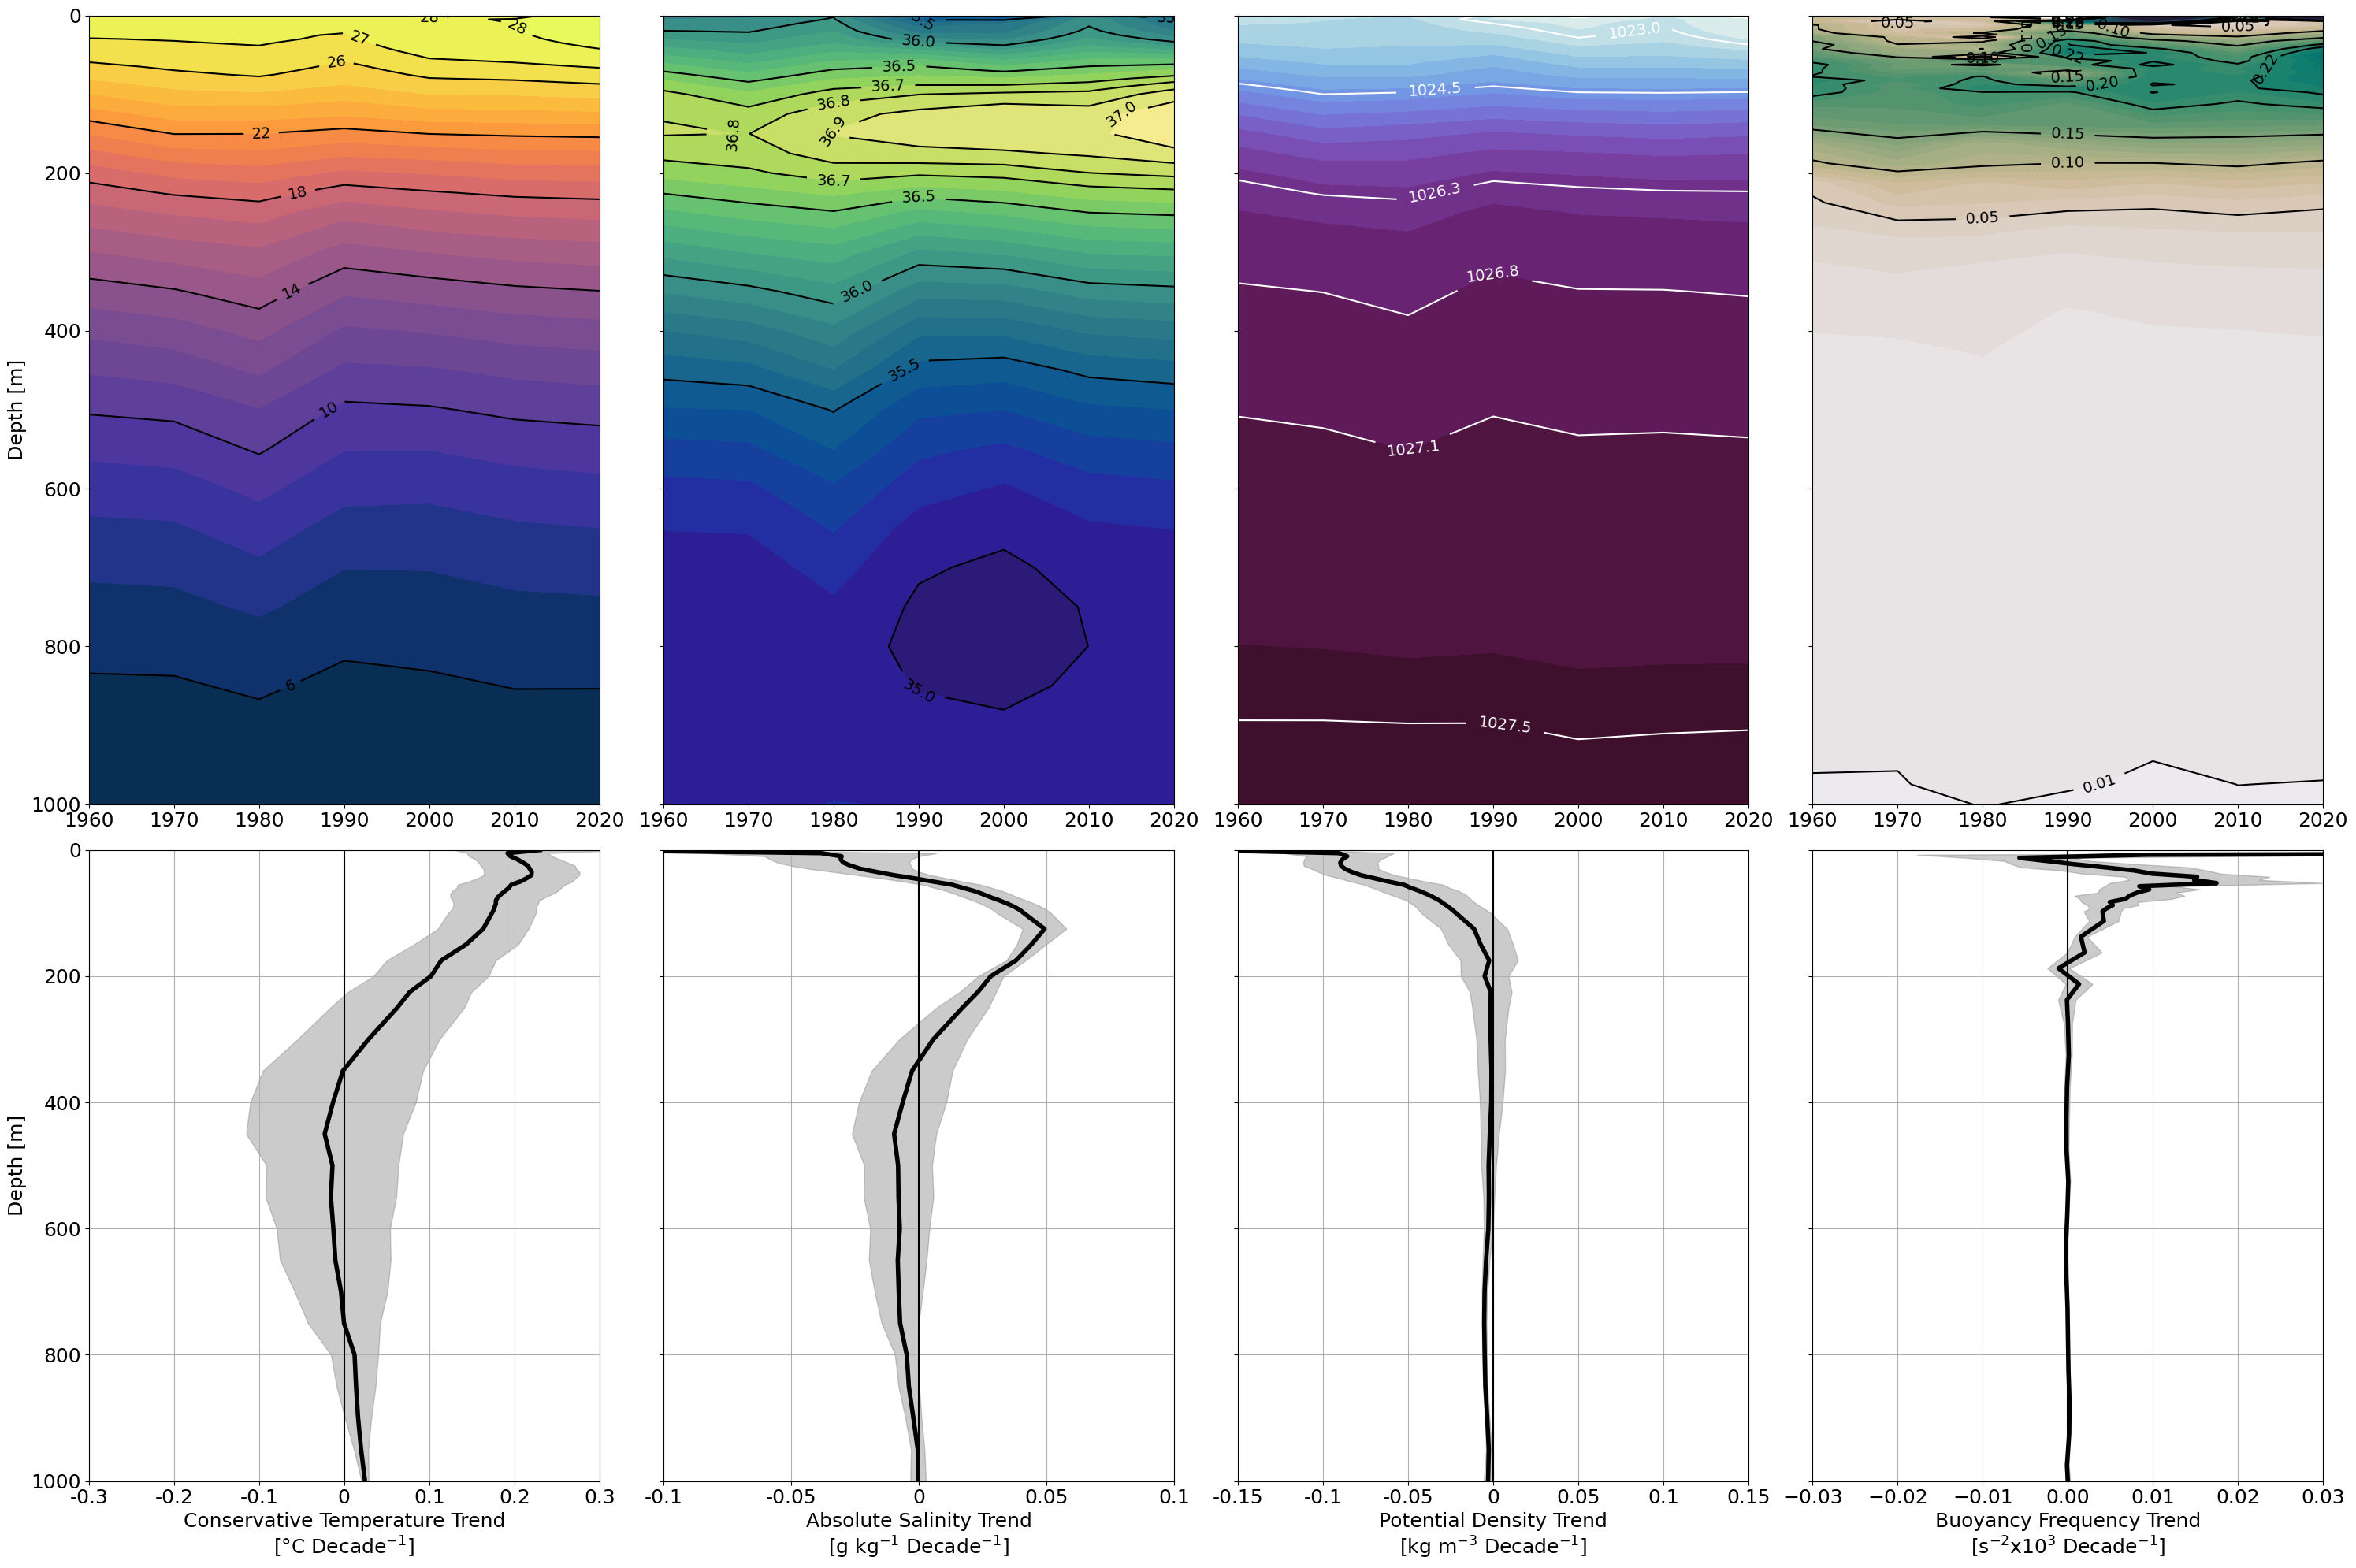

In [220]:
fontsize = 18

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30,20),gridspec_kw={'height_ratios': [5,4]})
#fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(26,22))


plt0 = ax[0,0].contourf(plot_decades,ds.depth,decadal_mean_temperature_profile,levels=np.arange(4,29,1),cmap=cmo.thermal,extend='max')
ax[0,0].set_ylim(1000,0)
ax[0,0].set_xlim(1960,2020)
ax[0,0].set_ylabel('Depth [m]',fontsize=fontsize)
ax[0,0].set_xlabel('')
ax[0,0].tick_params(axis='both', which='major', labelsize=fontsize)
CS = ax[0,0].contour(plot_decades,ds.depth,decadal_mean_temperature_profile,[6,10,14,18,22,26,27,28],colors='black',linewidth=5)
ax[0,0].clabel(CS, inline=True, fontsize=fontsize-4)


plt1 = ax[0,1].contourf(plot_decades,ds.depth,decadal_mean_salinity_profile,levels=np.arange(34.9,37.1,0.1),cmap=cmo.haline)
ax[0,1].set_ylim(1000,0)
ax[0,1].set_xlim(1960,2020)
ax[0,1].set_yticklabels('')
ax[0,1].tick_params(axis='x', which='major', labelsize=fontsize)
CS = ax[0,1].contour(plot_decades,ds.depth,decadal_mean_salinity_profile,[35,35.5,36,36.5,36.7,36.8,36.9,37],colors='black',linewidth=5)
ax[0,1].clabel(CS, inline=True, fontsize=fontsize-4)


plt2 = ax[0,2].contourf(plot_decades,ds.depth,decadal_mean_density_profile,levels=np.arange(1022.6,1027.81,0.3),cmap=cmo.dense)
ax[0,2].set_ylim(1000,0)
ax[0,2].set_xlim(1960,2020)
ax[0,2].set_yticklabels('')
ax[0,2].tick_params(axis='x', which='major', labelsize=fontsize)
CS = ax[0,2].contour(plot_decades,ds.depth,decadal_mean_density_profile,[1023,1024.5,1026.3,1026.8,1027.1,1027.5],colors='white',linewidth=5)
ax[0,2].clabel(CS, inline=True, fontsize=fontsize-4)


plt3 = ax[0,3].contourf(plot_decades,np.nanmean(depthN2,axis=1),decadal_mean_N2*(10**3),levels=np.arange(0,0.41,0.01),extend='max',cmap=cmo.rain)
ax[0,3].set_ylim(1000,0)
ax[0,3].set_xlim(1960,2020)
ax[0,3].set_yticklabels('')
ax[0,3].tick_params(axis='x', which='major', labelsize=fontsize)
CS = ax[0,3].contour(plot_decades,np.nanmean(depthN2,axis=1),decadal_mean_N2*(10**3),[0.01,0.05,0.1,0.15,0.2,0.22],colors='black',linewidth=5)
ax[0,3].clabel(CS, inline=True, fontsize=fontsize-4)



ax[1,0].plot(decadal_slope_temp*10,ds.depth,color='black',linewidth=4)
ax[1,0].fill_betweenx(ds.depth, decadal_slope_temp*10 - decadal_e_temp*10, decadal_slope_temp*10 + decadal_e_temp*10, color='tab:grey', alpha=0.4)
ax[1,0].set_ylim(1000,0)
ax[1,0].set_xlim(-0.3,0.3)
ax[1,0].grid()
ax[1,0].axvline(0, color='black')
ax[1,0].set_ylabel('Depth [m]',fontsize=fontsize)
ax[1,0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1,0].set_xlabel('Conservative Temperature Trend\n[°C Decade$^{-1}$]',fontsize=fontsize)
ax[1,0].set_xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])
ax[1,0].set_xticklabels([-0.3,-0.2,-0.1,0,0.1,0.2,0.3])


ax[1,1].plot(decadal_slope_salt*10,ds.depth,color='black',linewidth=4)
ax[1,1].fill_betweenx(ds.depth, decadal_slope_salt*10 - decadal_e_salt*10, decadal_slope_salt*10 + decadal_e_salt*10, color='tab:grey', alpha=0.4)
ax[1,1].set_ylim(1000,0)
ax[1,1].set_xlim(-0.1,0.1)
ax[1,1].grid()
ax[1,1].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1,1].set_xlabel('Absolute Salinity Trend\n[g kg$^{-1}$ Decade$^{-1}$]',fontsize=fontsize)
ax[1,1].set_yticklabels('')
ax[1,1].set_xticks([-0.1,-0.05,0,0.05,0.1])
ax[1,1].set_xticklabels([-0.1,-0.05,0,0.05,0.1])
ax[1,1].axvline(0, color='black')


ax[1,2].plot(decadal_slope_den*10,ds.depth,color='black',linewidth=4)
ax[1,2].fill_betweenx(ds.depth, decadal_slope_den*10 - decadal_e_den*10, decadal_slope_den*10 + decadal_e_den*10, color='tab:grey', alpha=0.4)
ax[1,2].set_ylim(1000,0)
ax[1,2].set_xlim(-0.15,0.15)
ax[1,2].grid()
ax[1,2].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1,2].set_xlabel('Potential Density Trend\n[kg m$^{-3}$ Decade$^{-1}$]',fontsize=fontsize)
ax[1,2].set_yticklabels('')
ax[1,2].set_xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
ax[1,2].set_xticklabels([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
ax[1,2].axvline(0, color='black')




ax[1,3].plot(decadal_slope_n2*10*(10**3),depthN2[:,0],color='black',linewidth=4)
ax[1,3].fill_betweenx(depthN2[:,0], decadal_slope_n2*10*(10**3) - decadal_e_n2*10*(10**3), decadal_slope_n2*10*(10**3) + decadal_e_n2*10*(10**3), color='tab:grey', alpha=0.4)
ax[1,3].set_ylim(1000,0)
ax[1,3].set_xlim(-0.03,0.03)
ax[1,3].grid()
ax[1,3].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1,3].set_xlabel('Buoyancy Frequency Trend\n[s$^{-2}$x10$^{3}$ Decade$^{-1}$]',fontsize=fontsize)
ax[1,3].set_yticklabels('')
#ax[3].set_xticks([-0.1,0,0.1,])
#ax[3].set_xticklabels([-0.1,0,0.1])
ax[1,3].axvline(0, color='black')

fig.tight_layout()

plt.savefig('/Users/joegradone/Desktop/Caribbean_Water_Mass_Analysis_Decadal_Mean_Temp_Salt_Den_N2_Pcolor_and_Trends.png',dpi=300,facecolor='white',bbox_inches='tight')


## Contributions of temp and salinity to density change

In [165]:
#decadal_mean_temperature_profile

x=1
alpha = gsw.alpha(decadal_mean_salinity_profile[x,0],decadal_mean_temperature_profile[x,0],gsw.p_from_z(-ds.depth.values[x], 15, geo_strf_dyn_height=0, sea_surface_geopotential=0))
beta = gsw.beta(decadal_mean_salinity_profile[x,0],decadal_mean_temperature_profile[x,0],gsw.p_from_z(-ds.depth.values[x], 15, geo_strf_dyn_height=0, sea_surface_geopotential=0))

In [166]:
alpha*(decadal_mean_temperature_profile[x,-1]-decadal_mean_temperature_profile[x,0])+(beta*(decadal_mean_salinity_profile[x,-1]-decadal_mean_salinity_profile[x,0]))

0.0001883184410494752

In [167]:
decadal_mean_density_profile[x,-1]-decadal_mean_density_profile[x,0]

-0.5088731532509883

In [168]:
decadal_mean_density_profile[0,0]

1023.0760785634061

In [169]:
decadal_mean_temperature_profile.shape

(55, 7)

In [170]:
ps = np.tile(gsw.p_from_z(-ds.depth,15),(decadal_mean_temperature_profile.shape[1],1)).transpose()

Tu, Rsubrho, p_mid = gsw.Turner_Rsubrho(decadal_mean_salinity_profile, decadal_mean_temperature_profile, ps, axis=0)


# For Tu > 0, the contribution of temperature to the stratification is dominant; for Tu < 0, the contribution of salinity is dominant. 

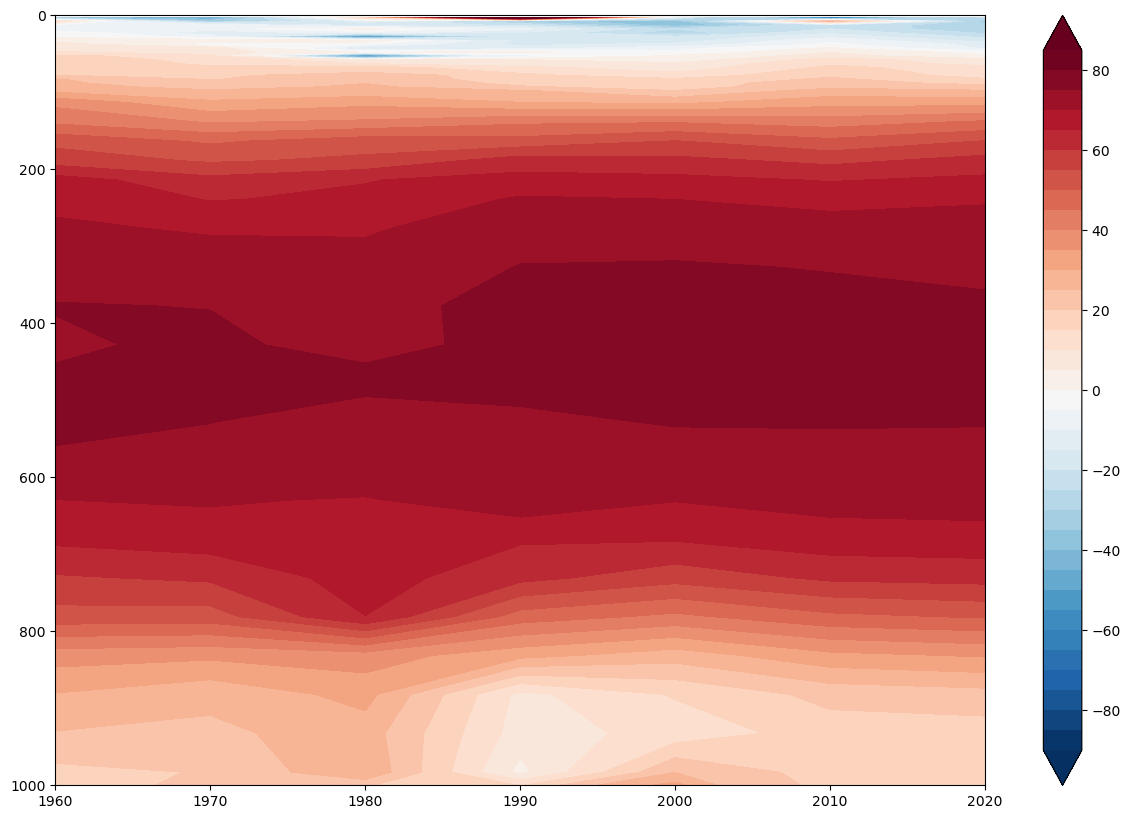

In [171]:
plt.figure(figsize=(15,10))
plt.contourf(plot_decades,p_mid[:,0],Tu,cmap='RdBu_r',levels=np.arange(-90,90,5),extend='both')
plt.ylim(1000,0)
plt.colorbar()

In [172]:
decadal_slope_tu = np.empty((Tu.shape[0]))
decadal_slope_tu[:] = np.nan
decadal_intercept_tu = np.empty((Tu.shape[0]))
decadal_intercept_tu[:] = np.nan
decadal_r_tu = np.empty((Tu.shape[0]))
decadal_r_tu[:] = np.nan
decadal_p_tu = np.empty((Tu.shape[0]))
decadal_p_tu[:] = np.nan
decadal_e_tu = np.empty((Tu.shape[0]))
decadal_e_tu[:] = np.nan



for x in np.arange(0,Tu.shape[0]):
    decadal_slope_tu[x], decadal_intercept_tu[x], decadal_r_tu[x], decadal_p_tu[x], decadal_e_tu[x] = linregress(plot_decades, Tu[x,:])


In [173]:
np.nanmean(decadal_slope_tu[0:10]*10)

-2.5560492701615027

In [174]:
decadal_p_tu[0:10]

array([0.91926381, 0.80500232, 0.04060418, 0.04477246, 0.02893004,
       0.75610612, 0.04762186, 0.11056914, 0.32329696, 0.09013267])

Text(0.5, 0, 'Turner Angle Trend [Degrees/Decades]')

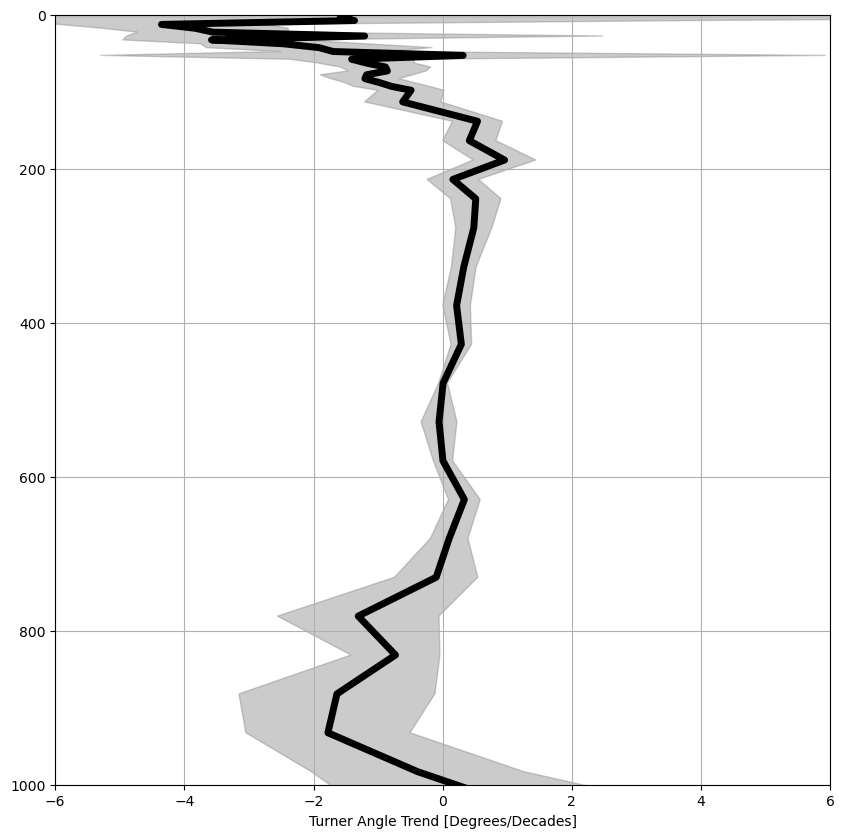

In [175]:
plt.figure(figsize=(10,10))
plt.plot(decadal_slope_tu*10,p_mid[:,0],color='k',linewidth=5)
plt.fill_betweenx(p_mid[:,0], decadal_slope_tu*10 - decadal_e_tu*10, decadal_slope_tu*10 + decadal_e_tu*10, color='tab:grey', alpha=0.4)

plt.ylim(1000,0)
plt.xlim(-6,6)
plt.grid()
plt.xlabel('Turner Angle Trend [Degrees/Decades]')

Text(0, 0.5, 'Depth [meters]')

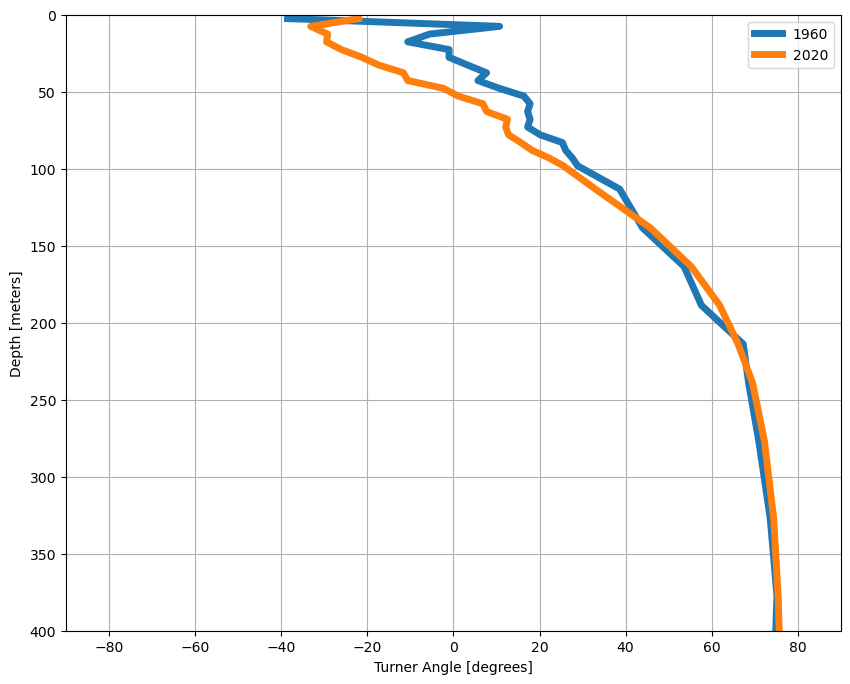

In [176]:
plt.figure(figsize=(10,8))
plt.plot(Tu[:,0],p_mid[:,0],label='1960',linewidth=5)
plt.plot(Tu[:,-1],p_mid[:,0],label='2020',linewidth=5)
plt.ylim(400,0)
plt.xlim(-90,90)
plt.grid()
plt.legend()
plt.xlabel('Turner Angle [degrees]')
plt.ylabel('Depth [meters]')

# The density of the upper 50 meters has beccome more salinity driven than temperature driven which implies a shift to a regime dominanted by surface barrier layers

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_95689/1439136229.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cmo.thermal')


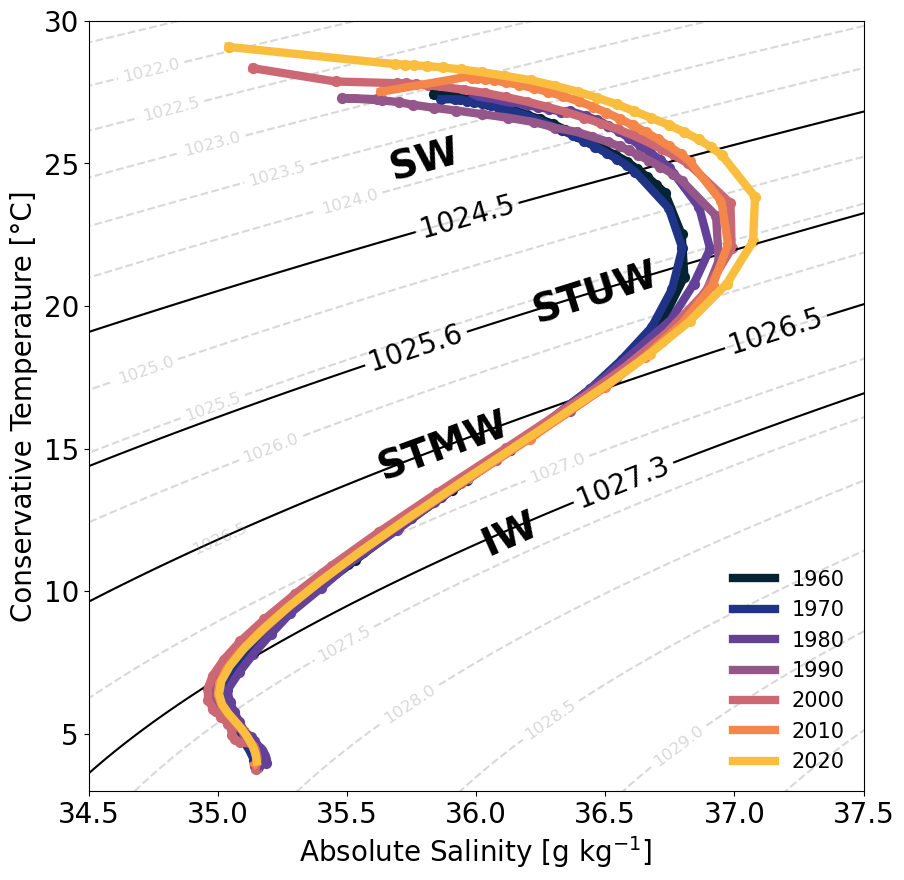

In [218]:
lwd=6
ps = 50
fontsize = 20


cmap = matplotlib.cm.get_cmap('cmo.thermal')
inds = np.arange(0,1.1,1/7)


plt.figure(figsize=(10,10))

plt.scatter(decadal_mean_salinity_profile[:,0],decadal_mean_temperature_profile[:,0],s=ps,color=cmap(inds[0]))
plt.plot(decadal_mean_salinity_profile[:,0],decadal_mean_temperature_profile[:,0],linewidth=lwd,label='1960',color=cmap(inds[0]))

plt.scatter(decadal_mean_salinity_profile[:,1],decadal_mean_temperature_profile[:,1],s=ps,color=cmap(inds[1]))
plt.plot(decadal_mean_salinity_profile[:,1],decadal_mean_temperature_profile[:,1],linewidth=lwd,label='1970',color=cmap(inds[1]))

plt.scatter(decadal_mean_salinity_profile[:,2],decadal_mean_temperature_profile[:,2],s=ps,color=cmap(inds[2]))
plt.plot(decadal_mean_salinity_profile[:,2],decadal_mean_temperature_profile[:,2],linewidth=lwd,label='1980',color=cmap(inds[2]))

plt.scatter(decadal_mean_salinity_profile[:,3],decadal_mean_temperature_profile[:,3],s=ps,color=cmap(inds[3]))
plt.plot(decadal_mean_salinity_profile[:,3],decadal_mean_temperature_profile[:,3],linewidth=lwd,label='1990',color=cmap(inds[3]))

plt.scatter(decadal_mean_salinity_profile[:,4],decadal_mean_temperature_profile[:,4],s=ps,color=cmap(inds[4]))
plt.plot(decadal_mean_salinity_profile[:,4],decadal_mean_temperature_profile[:,4],linewidth=lwd,label='2000',color=cmap(inds[4]))

plt.scatter(decadal_mean_salinity_profile[:,5],decadal_mean_temperature_profile[:,5],s=ps,color=cmap(inds[5]))
plt.plot(decadal_mean_salinity_profile[:,5],decadal_mean_temperature_profile[:,5],linewidth=lwd,label='2010',color=cmap(inds[5]))

plt.scatter(decadal_mean_salinity_profile[:,6],decadal_mean_temperature_profile[:,6],s=ps,color=cmap(inds[6]))
plt.plot(decadal_mean_salinity_profile[:,6],decadal_mean_temperature_profile[:,6],linewidth=lwd,label='2020',color=cmap(inds[6]))


plt.ylim(3,30)
plt.xlim(34.5,37.5)
plt.ylabel('Conservative Temperature [°C]',size=fontsize)
plt.xlabel('Absolute Salinity [g kg$^{-1}$]',size=fontsize)
plt.legend(loc='lower right',markerscale=1.5,frameon=False, fontsize=font_size)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)






######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
n =499
tempL=np.linspace(mint-1,maxt+1,n)
salL=np.linspace(mins-1,maxs+1,n)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,n)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),n)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]

## Thin bois
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', alpha=0.3,linestyles='dashed', zorder=1 ,levels=np.arange(1021,1030,0.5))
levels = cs.levels
manual_locations = [(0, 0), (0, 0),(0, 0), (34.75, 28),(34.8, 27.6), (35.25,24), (35.5, 24), (35, 25),(34.75, 17), (35, 16),(35.25,14), (0,0), (35,12),(0,0),(36.35,13.5), (0,0), (35.5,8),(35.75,6),(36.25,6),(36.75,5)]
plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)

# Thick bois
#cs = plt.contour(Sg, Tg, sigma_theta, colors='black', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
cs = plt.contour(Sg, Tg, sigma_theta, colors='black', zorder=1 ,levels=[1024.5,1025.6,1026.5,1027.3])
levels = cs.levels
manual_locations = [(36, 22), (35.75,19), (37.2,18), (36.65,12)]
plt.clabel(cs,levels, fontsize=fontsize,inline=True,fmt='%.1f', manual=manual_locations)


plt.text(35.65,24.4,'SW',fontsize=28,weight='bold',rotation=15)
plt.text(36.2,19.4,'STUW',fontsize=28,weight='bold',rotation=17.5)
plt.text(35.6,13.9,'STMW',fontsize=28,weight='bold',rotation=20)
plt.text(36,11.25,'IW',fontsize=28,weight='bold',rotation=24)

plt.savefig('/Users/joegradone/Desktop/Caribbean_T_S_by_Decade.png',dpi=300,facecolor='white',bbox_inches='tight')


In [202]:
1026.3-0.35

1025.95

In [179]:
(1.2*(10**-5))/((6.8*(10**-8))*10)

17.64705882352941

## Water Mass Decomposition

In [180]:
test = water_mass_decomposition(decadal_mean_salinity_profile[:,0],decadal_mean_temperature_profile[:,0],decadal_mean_density_profile[:,0],decadal_mean_salinity_profile[:,-1],decadal_mean_temperature_profile[:,-1],decadal_mean_density_profile[:,-1],ds.depth.values)
test

depth  temp_diff  heave_temp  spice_temp  temp_resid  salt_diff  \
0       0   1.665922   -4.821533    0.648438   -3.804049  -0.796279   
1       5   1.078427   -2.172959    0.663635   -1.758167  -0.212313   
2      10   1.141033   -0.146906    0.593673    0.400455  -0.197444   
3      15   1.192295   -0.161797    0.668754    0.361744  -0.199458   
4      20   1.229935   -0.231072    0.547534    0.451329  -0.193978   
5      25   1.271541   -0.291795    0.636051    0.343695  -0.172619   
6      30   1.318466   -0.411078    0.544113    0.363274  -0.153997   
7      35   1.353047   -0.451976    0.673318    0.227753  -0.122891   
8      40   1.376607   -0.564172    0.606676    0.205759  -0.084690   
9      45   1.364899   -0.679390    0.520190    0.165319  -0.035448   
10     50   1.347203   -0.596464    0.691467    0.059272   0.005451   
11     55   1.331104   -0.645354    0.642554    0.043196   0.049542   
12     60   1.322633   -0.670599    0.619175    0.032860   0.079661   
13     65   1.323946   -0.700476    0.602090    0.021380   0.104454   
14     70   1.309712   -0.716938    0.577157    0.015617   0.122331   
15     75   1.297633   -0.480372    0.801553    0.015707   0.139137   
16     80   1.284273   -0.496080    0.775589    0.012605   0.160974   
17     85   1.301941   -0.508684    0.774423    0.018834   0.181897   
18     90   1.314237   -0.527519    0.766498    0.020220   0.199181   
19     95   1.319107   -0.273869    1.042385    0.002853   0.212116   
20    100   1.323902   -0.000000    1.323902    0.000000   0.220270   
21    125   1.315825   -0.000000    1.315825    0.000000   0.284045   
22    150   1.237947   -0.000000    1.237947    0.000000   0.265804   
23    175   1.085111   -0.000000    1.085111    0.000000   0.237473   
24    200   1.015634   -6.133857   -0.121616   -4.996607   0.190454   
25    225   0.834377   -5.369501   -0.176173   -4.358950   0.169428   
26    250   0.732323   -0.000000    0.732323    0.000000   0.144063   
27    300   0.577927   -0.000000    0.577927    0.000000   0.097168   
28    350   0.438552   -0.000000    0.438552    0.000000   0.061071   
29    400   0.386753   -0.000000    0.386753    0.000000   0.045934   
30    450   0.300864   -0.000000    0.300864    0.000000   0.019711   
31    500   0.251837   -9.606791   -0.632816   -8.722138   0.007852   
32    550   0.247800   -8.307999   -0.529146   -7.531053   0.013380   
33    600   0.231178   -7.379067   -0.467689   -6.680199   0.009599   
34    650   0.207563   -6.585193   -0.410609   -5.967021  -0.000705   
35    700   0.198864   -5.770978   -0.337160   -5.234954  -0.007387   
36    750   0.152359   -4.921060   -0.295829   -4.472872  -0.015072   
37    800   0.156698   -0.000000    0.156698    0.000000  -0.011114   
38    850   0.134124   -0.000000    0.134124    0.000000  -0.008228   
39    900   0.119265   -0.000000    0.119265    0.000000   0.000748   
40    950   0.117721   -0.000000    0.117721    0.000000   0.008856   
41   1000   0.121103   -0.000000    0.121103    0.000000   0.009148   
42   1050   0.075896   -0.000000    0.075896    0.000000   0.010915   
43   1100   0.072078   -0.000000    0.072078    0.000000   0.009615   
44   1150   0.073231   -0.000000    0.073231    0.000000   0.006425   
45   1200   0.091521   -0.000000    0.091521    0.000000   0.005313   
46   1250   0.096624   -0.804281    0.021120   -0.728777   0.001890   
47   1300   0.099126   -0.701350    0.034360   -0.636584   0.000223   
48   1350   0.101781   -1.213431   -0.004467   -1.107183  -0.001430   
49   1400   0.104710   -1.062476    0.010880   -0.968646  -0.003000   
50   1450   0.107769   -0.938301    0.023465   -0.853997  -0.003585   
51   1500   0.110458   -2.529126   -0.068638   -2.350030  -0.004068   
52   1550   0.102650   -4.477401   -0.036301   -4.338450  -0.003321   
53   1800   0.088052         NaN    0.088052         NaN  -0.001161   
54   2050        NaN         NaN    0.148669         NaN        NaN   

    heave_salt  spice_salt 

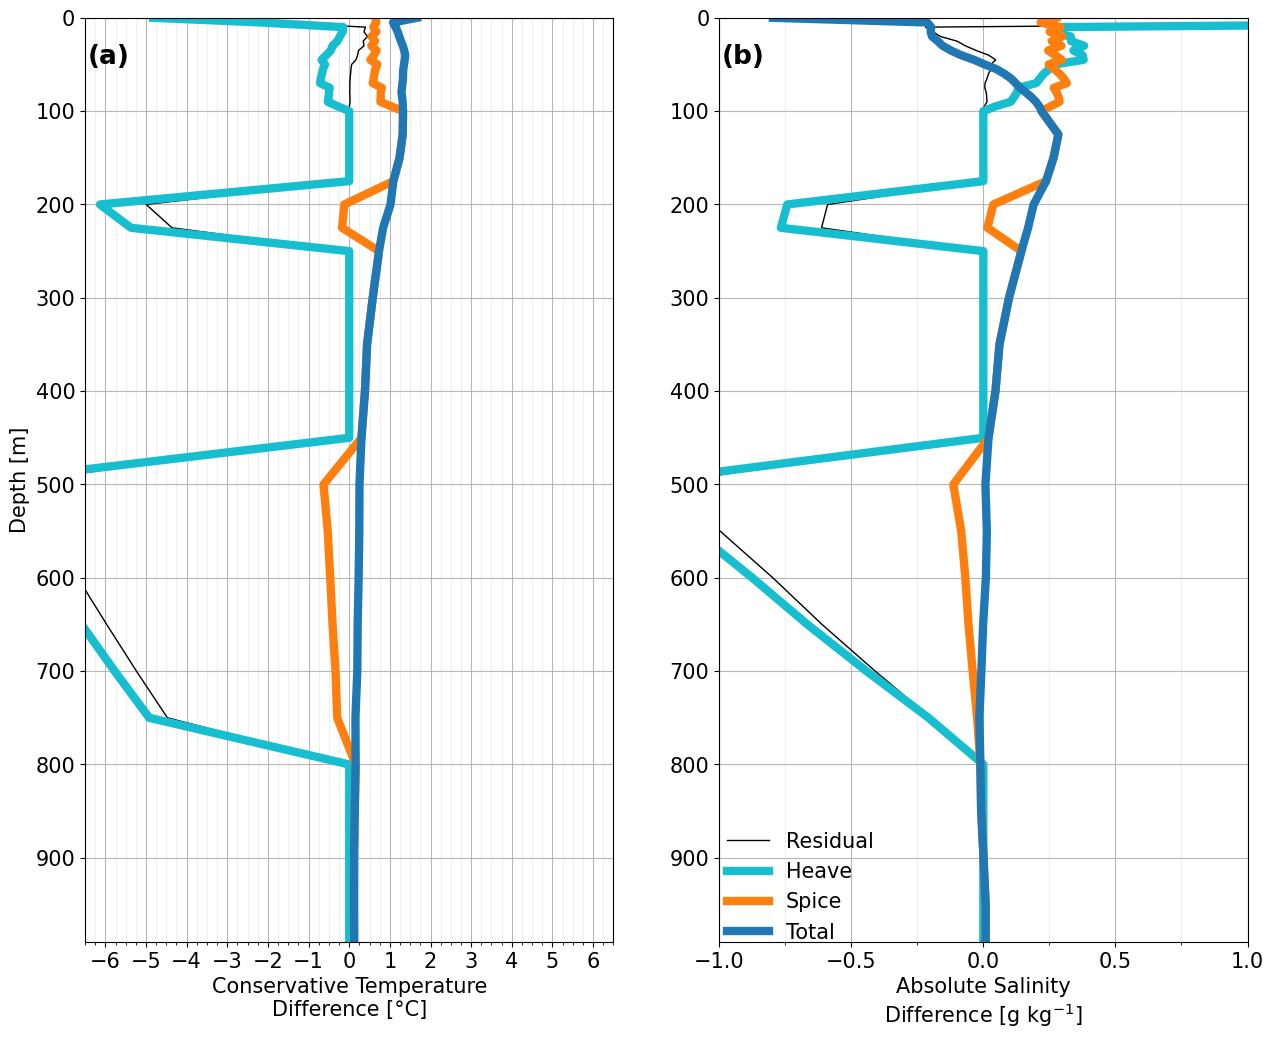

In [181]:

title_size = 19
font_size = 15

sal_major_ticks = np.arange(-1, 1.01, 0.5)
sal_minor_ticks = np.arange(-1, 1.01, 0.25)
temp_major_ticks = np.arange(-6, 6.01, 1)
temp_minor_ticks = np.arange(-6.5, 6.51, 0.25)

depth_ticks = np.arange(0, 950, 100)


fig, axs = plt.subplots(1, 2,figsize=(15, 12))

axs[0].plot(test.temp_resid, test.depth, label='Residual',linewidth=1, color='black')
axs[0].plot(test.heave_temp, test.depth, label='Heave',linewidth=lwd,color='tab:cyan')
axs[0].plot(test.spice_temp, test.depth, label='Spice',linewidth=lwd,color='tab:orange')    
axs[0].plot(test.temp_diff, test.depth, label='Total',linewidth=lwd,color='tab:blue')
axs[0].grid()
axs[0].set_ylim(990,0)
axs[0].set_xlim(-6,6)
axs[0].set_xlabel('Conservative Temperature\nDifference [°C]',fontsize=font_size)
axs[0].set_ylabel('Depth [m]',fontsize=font_size)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].text(0.005,0.95,'(a)', transform=axs[0].transAxes, size=title_size, weight='bold')

axs[1].plot(test.salt_resid, test.depth, label='Residual',linewidth=1, color='black')
axs[1].plot(test.heave_salt, test.depth, label='Heave',linewidth=lwd,color='tab:cyan')
axs[1].plot(test.spice_salt, test.depth, label='Spice',linewidth=lwd,color='tab:orange')
axs[1].plot(test.salt_diff, test.depth, label='Total',linewidth=lwd,color='tab:blue')

axs[1].grid()
axs[1].set_ylim(990,0)
axs[1].set_xlim(-1,1)
axs[1].set_xlabel('Absolute Salinity\nDifference [g kg$^{-1}$]',fontsize=font_size)
axs[1].legend(loc=(0,-0.01),frameon=False,fontsize=font_size)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].text(0.005,0.95,'(b)', transform=axs[1].transAxes, size=title_size, weight='bold')

## Grid stuff
axs[0].set_yticks(depth_ticks)
axs[1].set_yticks(depth_ticks)
axs[0].set_xticks(temp_major_ticks)
axs[0].set_xticks(temp_minor_ticks, minor=True)
axs[0].grid(which='minor', alpha=0.2)
axs[0].grid(which='major', alpha=0.9)
axs[1].set_xticks(sal_major_ticks)
axs[1].set_xticks(sal_minor_ticks, minor=True)
axs[1].grid(which='minor', alpha=0.2)
axs[1].grid(which='major', alpha=0.9)



## East, Central West

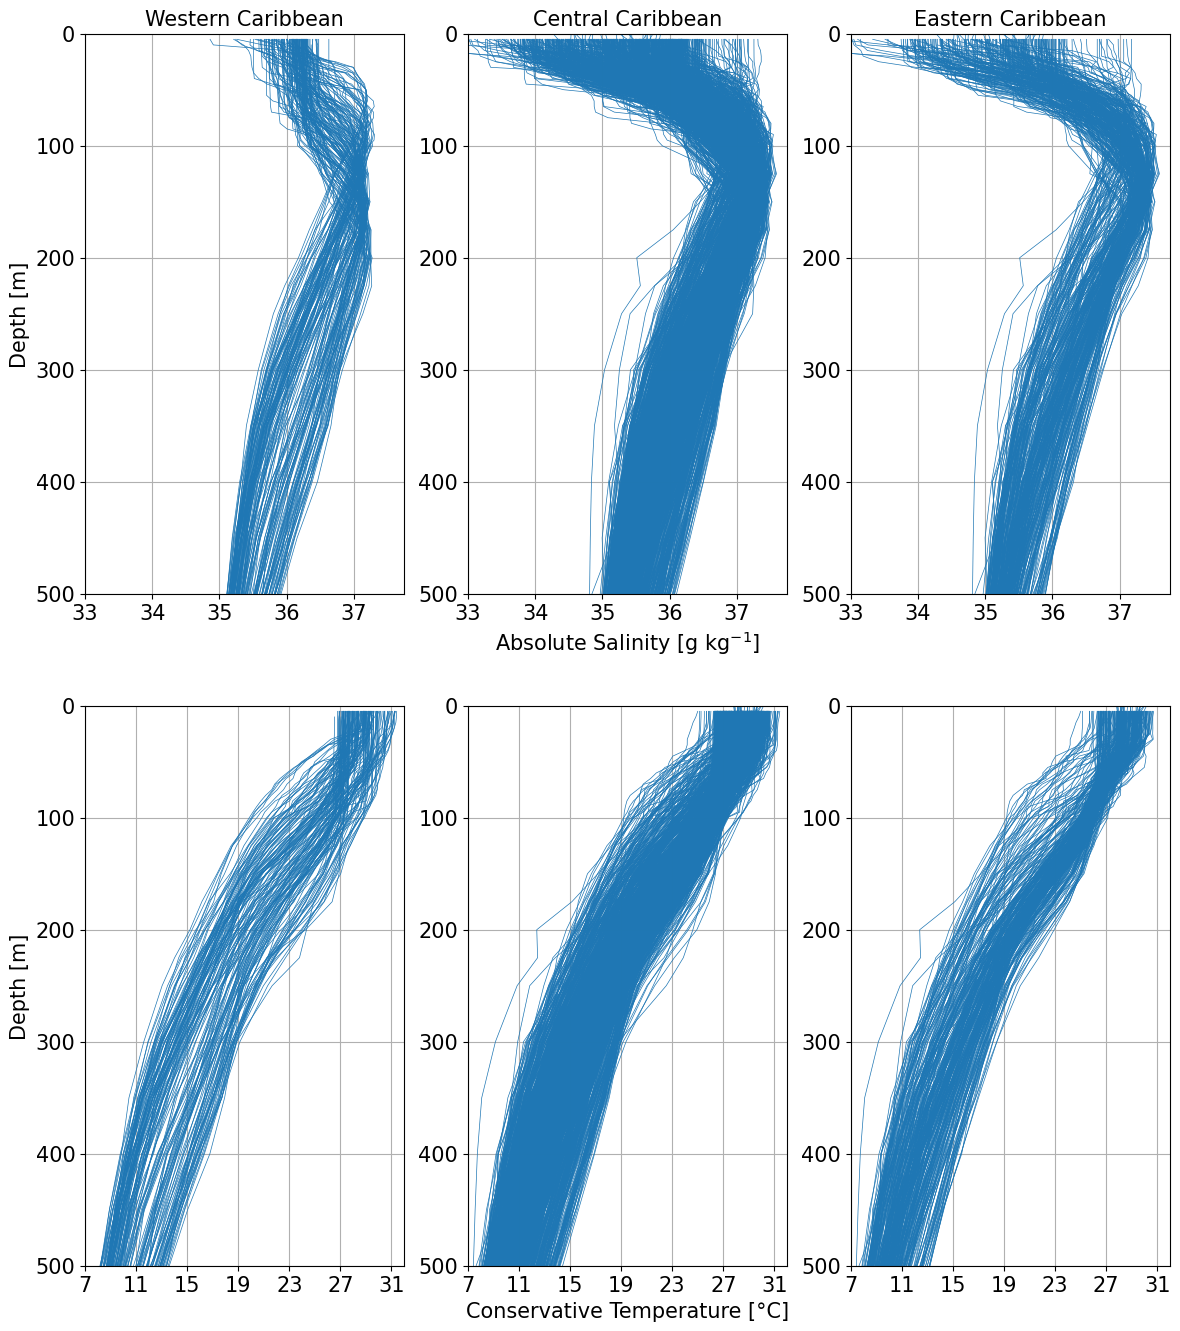

In [182]:
west_ds = ds.where((ds.time.dt.year>2020)&(ds.longitude<-80),drop=True)
central_ds = ds.where((ds.time.dt.year>2020)&(ds.longitude>-80),drop=True)
east_ds = ds.where((ds.time.dt.year>2020)&(ds.longitude>-66),drop=True)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,16))
lwd=0.5
for x in np.arange(0,len(west_ds.latitude.values)):
    for y in np.arange(0,len(west_ds.longitude.values)):
        for z in np.arange(0,len(west_ds.time.values)):
            ax[0,0].plot(west_ds.absolute_salinity[:,x,y,z],west_ds.depth,color='tab:blue',linewidth=lwd)

for x in np.arange(0,len(central_ds.latitude.values)):
    for y in np.arange(0,len(central_ds.longitude.values)):
        for z in np.arange(0,len(central_ds.time.values)):
            ax[0,1].plot(central_ds.absolute_salinity[:,x,y,z],central_ds.depth,color='tab:blue',linewidth=lwd)

for x in np.arange(0,len(east_ds.latitude.values)):
    for y in np.arange(0,len(east_ds.longitude.values)):
        for z in np.arange(0,len(east_ds.time.values)):
            ax[0,2].plot(east_ds.absolute_salinity[:,x,y,z],east_ds.depth,color='tab:blue',linewidth=lwd)

ax[0,0].set_ylim(500,0)
ax[0,1].set_ylim(500,0)
ax[0,2].set_ylim(500,0)
ax[0,0].set_xlim(33,37.75)
ax[0,1].set_xlim(33,37.75)
ax[0,2].set_xlim(33,37.75)
ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()

ax[0,0].set_xticks(np.arange(33, 37.6, 1))
ax[0,1].set_xticks(np.arange(33, 37.6, 1))
ax[0,2].set_xticks(np.arange(33, 37.6, 1))

ax[0,1].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize=font_size)
ax[0,0].set_ylabel('Depth [m]',fontsize=font_size)

ax[0,0].set_title('Western Caribbean',fontsize=font_size)
ax[0,1].set_title('Central Caribbean',fontsize=font_size)
ax[0,2].set_title('Eastern Caribbean',fontsize=font_size)

ax[0,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[0,2].tick_params(axis='both', which='major', labelsize=font_size)






for x in np.arange(0,len(west_ds.latitude.values)):
    for y in np.arange(0,len(west_ds.longitude.values)):
        for z in np.arange(0,len(west_ds.time.values)):
            ax[1,0].plot(west_ds.conservative_temperature[:,x,y,z],west_ds.depth,color='tab:blue',linewidth=lwd)

for x in np.arange(0,len(central_ds.latitude.values)):
    for y in np.arange(0,len(central_ds.longitude.values)):
        for z in np.arange(0,len(central_ds.time.values)):
            ax[1,1].plot(central_ds.conservative_temperature[:,x,y,z],central_ds.depth,color='tab:blue',linewidth=lwd)

for x in np.arange(0,len(east_ds.latitude.values)):
    for y in np.arange(0,len(east_ds.longitude.values)):
        for z in np.arange(0,len(east_ds.time.values)):
            ax[1,2].plot(east_ds.conservative_temperature[:,x,y,z],east_ds.depth,color='tab:blue',linewidth=lwd)

ax[1,0].set_ylim(500,0)
ax[1,1].set_ylim(500,0)
ax[1,2].set_ylim(500,0)
ax[1,0].set_xlim(7,32)
ax[1,1].set_xlim(7,32)
ax[1,2].set_xlim(7,32)
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()

ax[1,0].set_xticks(np.arange(7, 33, 4))
ax[1,1].set_xticks(np.arange(7, 33, 4))
ax[1,2].set_xticks(np.arange(7, 33, 4))

ax[1,1].set_xlabel('Conservative Temperature [°C]',fontsize=font_size)
ax[1,0].set_ylabel('Depth [m]',fontsize=font_size)

ax[1,0].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1,2].tick_params(axis='both', which='major', labelsize=font_size)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/figures/Python/Glider/WIMP_Glider_Decomposition/WCE_Caribbean_TS_Profiles_EN4.png',dpi=300,facecolor='white',bbox_inches='tight')



## Load AMO data

Obtained from: https://psl.noaa.gov/data/timeseries/AMO/

In [183]:
df1 = pd.read_csv('/Users/joegradone/Desktop/ersst.v5.amo.dat.txt',delim_whitespace=True)
df = pd.read_csv('/Users/joegradone/Desktop/amon.sm.data.txt',delim_whitespace=True,usecols=[0,1],names=['Year','SSTA'])
df.SSTA[np.where(df.SSTA==-99.990)[0]] = np.nan
df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/joegradone/Desktop/ersst.v5.amo.dat.txt'

In [ ]:
df1

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(df.Year,df.SSTA,'black',linewidth=5)
plt.fill_between(df.Year,0,df.SSTA,where=df.SSTA>0,color='tab:orange')

plt.fill_between(df.Year,0,df.SSTA,where=df.SSTA<0,color='tab:blue')
plt.scatter(df1.Year,df1.SSTA,alpha=0.5,color='black')
plt.grid()
plt.xlim(1960,2024)
plt.ylim(-1,1)
plt.ylabel('Atlantic SST Anomaly',fontsize=16)
plt.title('AMO Index',fontsize=16)

In [ ]:
pos_ind